In [56]:
#Importss
# import os
# os.environ['NUMEXPR_MAX_THREADS'] = 40
import numpy as np
from time import time
from tmu.models.classification.vanilla_classifier import TMClassifier
from scipy.sparse import lil_matrix
from skimage.util import view_as_windows
from sklearn.feature_extraction.text import CountVectorizer
import cv2
from skimage.transform import pyramid_gaussian, pyramid_laplacian, downscale_local_mean
import matplotlib.pyplot as plt #drawing plots
import matplotlib.patches as patches #drawing squares
from scipy.ndimage import rotate

import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

from tqdm import tqdm #runtime stats

import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets import cifar10


In [57]:
#Parameters

#TM
epochs = 10
max_included_literals = 500
clauses = 6
T = int((np.sqrt(clauses)/2 + 2)*10)
s = 1.5
step = 1
visual_tokens = True
encode_to_hypervec = False

#Data
#trained_labels = np.array([0,1,2,3])
trained_labels = np.arange(3)
training_pool_size = 200 # number of testing pictures loaded

#preprocessing
resolution = 4 # scaled colors to thermometer code size of..
patch_dim = [3,3]

# Dice Dataset parameters
Debug_dataset = True
train_size = training_pool_size
test_size = 100
window_top_left = (5, 5)
window_bottom_right = (32, 32)
dice_size = 12    

#Hypervector
scaling = 1
unique_patches = 2**9
hypervector_size = int(512*scaling)

#Encoding
bits = np.maximum(5, int(5*scaling))
indexes = np.arange(hypervector_size, dtype=np.uint32)
encoding = np.zeros((unique_patches, hypervector_size), dtype=np.uint32)
for i in range(unique_patches):
        selection = np.random.choice(indexes, size=(bits))
        encoding[i][selection] = 1
        
labels = ["Airplane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

        

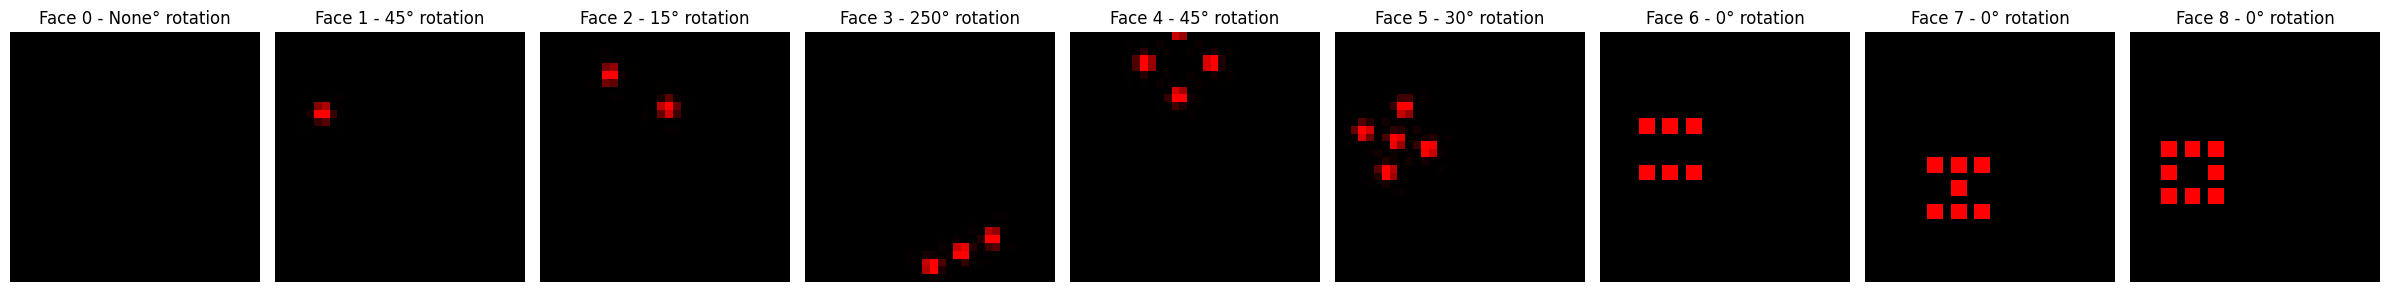

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import random

def dice_image(value, top_left=(0, 0), bottom_right=(32, 32), dice_size=8, rand_placement=False, rotation_angle=None):
    img = np.zeros((32, 32, 3), dtype=np.uint8)
    
    # Relative dot size
    dot_size = dice_size // 6
    if dot_size<1:dot_size=1
    
    dot_color = (255, 0, 0)  # Red color
    
    if value not in range(0, 10):
        raise ValueError("Dice value should be between 0 and 10.")

    
    # Relative positions for the center of dice based on its value and dice size
    offset = dice_size // 4
    positions = {
        1: [(-offset, -offset)],
        2: [(-offset, -offset), (offset, offset)],
        3: [(-offset, -offset), (0, 0), (offset, offset)],
        4: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset)],
        5: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0)],
        6: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset)],
        7: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset)],
        8: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset), (-offset, 0), (offset, 0)],
        9: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset), (-offset, 0), (offset, 0)]
    }
    if rand_placement:
        # Generate a random position within the window for the center of the dice
        center_x = random.randint(top_left[0] + dice_size // 2, bottom_right[0] - dice_size // 2)
        center_y = random.randint(top_left[1] + dice_size // 2, bottom_right[1] - dice_size // 2)
    else:
        center_y = bottom_right[1] - top_left[1]
        center_x = bottom_right[0] - top_left[0]
    if value != 0:
        for pos in positions[value]:
            x = center_x + pos[0]
            y = center_y + pos[1]
            img[y-dot_size//2:y+dot_size//2, x-dot_size//2:x+dot_size//2] = dot_color

    # Rotation logic
    if rotation_angle is not None:
        if rotation_angle in [90, 180, 270]:
            img = np.rot90(img, k=rotation_angle // 90)
        else:
            img = rotate(img, rotation_angle, reshape=False, mode='nearest')

    return img

# Plotting the dice faces with random positions and rotations within the specified window
window_top_left = (0, 0)
window_bottom_right = (32, 32)
dice_size = 12
fig, axes = plt.subplots(1, 9, figsize=(24, 4))

rotations = [None, 45, 15, 250, 45, 30, 0, 0, 0 ,0]  # Some sample rotations

for ax, value, rot in zip(axes, range(0, 10), rotations):
    ax.imshow(dice_image(value, window_top_left, window_bottom_right, dice_size, True, rot))
    ax.axis("off")
    ax.set_title(f"Face {value} - {rot}° rotation")

plt.tight_layout()
plt.show()

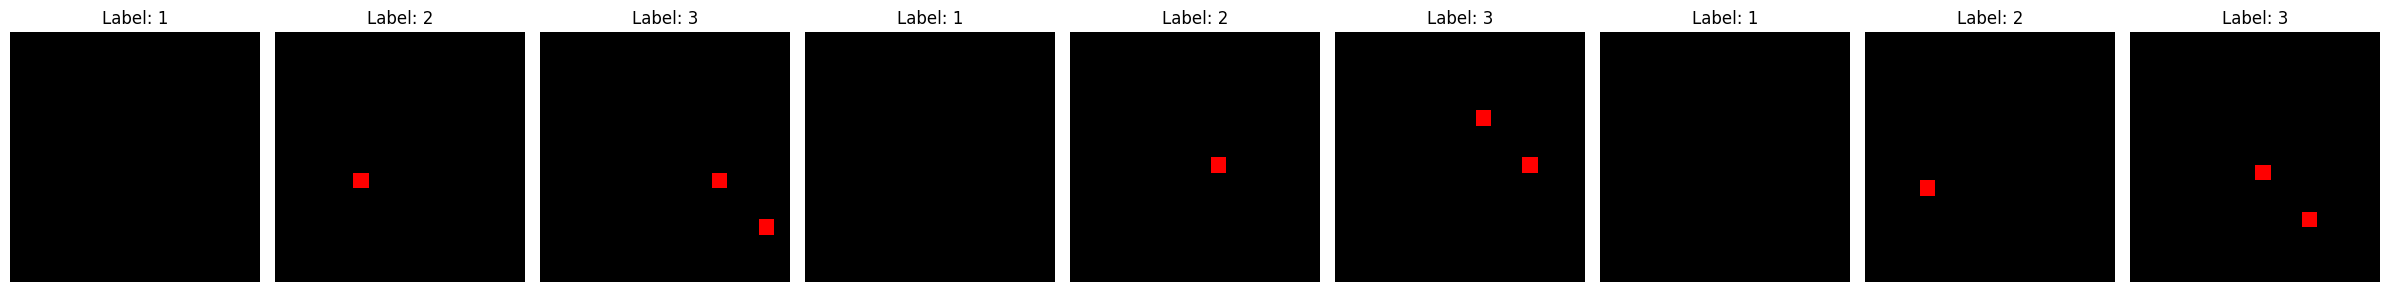

(100, 32, 32, 3)
(100,)
(20, 32, 32, 3)
(20,)


In [59]:
#Dataset
if Debug_dataset:
    def generate_dataset(dataset_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, include_random_class=False, random_placement=False):
        dataset = np.zeros((dataset_size, 32, 32, 3), dtype=np.uint8)
        labels = np.zeros((dataset_size,), dtype=np.uint8)
        
        #rotations = [None, 90, 180, 270]
        rotations = [None, 90, 180, 270]
        if not random_rotations:
            rotations = [None]
        
        for i in range(dataset_size):
            dice_val = trained_labels[(i % len(trained_labels))]
            rot = random.choice(rotations)
            # If the random class is to be included and the current index is for the random class
            if include_random_class and dice_val == 10:
                # Create a random pixel image
                dataset[i] = np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8)
                labels[i] = 10  # The label for the random class
            else:
                # Create a dice image
                dataset[i] = dice_image(value=dice_val, top_left=window_top_left, bottom_right=window_bottom_right, dice_size=dice_size, rotation_angle=rot, rand_placement=random_placement)
                labels[i] = dice_val  # Making labels 0-indexed
        
        return dataset, labels

    

    # Generate datasets
    X_train_org, Y_train_org = generate_dataset(train_size, window_top_left, window_bottom_right, dice_size, include_random_class=True, random_rotations=False, random_placement=True)
    X_test_org, Y_test_org = generate_dataset(test_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, random_placement=True)

    # Display some sample images from the training set
    fig, axes = plt.subplots(1, 9, figsize=(24, 4))
    for i in range(9):
        ax = axes[i]
        ax.imshow(X_train_org[i])
        ax.axis("off")
        ax.set_title(f"Label: {Y_train_org[i]+1}")

    plt.tight_layout()
    plt.show()
    labels = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
    
else:

    #Load cifar10
    (X_train_org, Y_train_org), (X_test_org, Y_test_org) = cifar10.load_data()

    #adjust to train pool size
    X_test_org = X_test_org[0:training_pool_size]
    Y_test_org = Y_test_org.reshape(Y_test_org.shape[0])[0:training_pool_size]
    X_train_org = X_train_org[0:training_pool_size]
    Y_train_org = Y_train_org.reshape(Y_train_org.shape[0])[0:training_pool_size]

    #filter only desired labels
    X_train_org = X_train_org[np.in1d(Y_train_org, trained_labels)]
    Y_train_org = Y_train_org[np.in1d(Y_train_org, trained_labels)]

X_test_org = X_test_org[np.in1d(Y_test_org, trained_labels)]
Y_test_org = Y_test_org[np.in1d(Y_test_org, trained_labels)]

print(X_train_org.shape)
print(Y_train_org.shape)
print(X_test_org.shape)
print(Y_test_org.shape)



In [60]:
def calculateGradient(images, plot_it=False):
    num_images, height, width, channels = images.shape
    gradients = np.zeros((num_images, height, width, 2), dtype=images.dtype)  # Store mag and angle
    
    for i in range(num_images):
        image = images[i]
        
        if image.dtype == np.float64:
            image = image.astype(np.float32)

        # Check if the image is already grayscale
        if channels == 1:
            gray = image
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=1)
        gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=1)
        mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
        gradients[i, :, :, 0] = mag
        gradients[i, :, :, 1] = angle
        
        if plot_it:
            # Visualization for each image
            plt.figure(figsize=(20, 8))

            plt.subplot(1, 4, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')

            plt.subplot(1, 4, 2)
            plt.imshow(np.abs(gx), cmap='gray')
            plt.title('Gradient X')

            plt.subplot(1, 4, 3)
            plt.imshow(np.abs(gy), cmap='gray')
            plt.title('Gradient Y')

            plt.subplot(1, 4, 4)
            plt.imshow(mag, cmap='gray')
            plt.title('Gradient Magnitude')

            plt.tight_layout()
            plt.show()
    
    return gradients

# Example usage:
# Assuming X_train_org is your dataset of shape (num_images, height, width, RGB)
# calculateGradient(X_train_org[:1], plot_it=True)  # Here, I'm using only the first 2 images for demonstration

# For individual images
# print(labels[Y_train_org[7]])
# _ = calculateGradient(X_train_org[7:8], plot_it=True)


In [61]:
# Thermometer Coding
def thermometer_encode(image, resolution=8, prevMin=0, prevMax=255):
    # Get the shape of the input image
    shape = image.shape
    
    # Initialize the thermometer encoded image array
    encoded_image = np.empty(shape + (resolution,), dtype=np.uint8)
    
    # Perform thermometer encoding
    scale_factor = (prevMax - prevMin) / (resolution + 1)
    for z in range(resolution):
        encoded_image[..., z] = image >= prevMin + (z + 1) * scale_factor
    
    return encoded_image

def thermometer_decode(encoded_image, resolution, toMin=0, toMax=255):
    # Sum along the last dimension and scale back to the original range
    scale_factor = (toMax - toMin) / (resolution + 1)
    decoded_image = toMin + np.sum(encoded_image, axis=-1) * scale_factor
    
    # Cast the decoded image to uint8 data type
    decoded_image = decoded_image.astype(np.uint8)
    
    return decoded_image


In [62]:
def test_ThermEncodeAndDecode(original_image, thermometer_encode, thermometer_decode, resolution):
    # Encode the original image
    encoded_image = thermometer_encode(original_image, resolution)
    print(encoded_image[0])
    # Decode the encoded image back to the original form
    decoded_image = thermometer_decode(encoded_image, resolution)

    # Visualization
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(decoded_image)
    plt.title('Decoded Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Call the test function
#test_ThermEncodeAndDecode(np.full((32,32,3),223), thermometer_encode, thermometer_decode, 8)


In [63]:
def create_windowed_dataset(*datasets, patch_dim):
    # Ensure that there is at least one dataset provided
    if len(datasets) == 0:
        raise ValueError("At least one dataset must be provided")
    
    # Get the common shape for num_images, height, and width from the first dataset
    common_shape = datasets[0].shape[:3]
    
    # Validate the shapes of the datasets
    for dataset in datasets:
        if dataset.shape[:3] != common_shape:
            raise ValueError(f"All datasets must have the same num_images, height, and width. Expected shape: {common_shape}, but got {dataset.shape[:3]}")

    
    # Find the maximum size along the fourth dimension
    max_dim_4 = max(dataset.shape[3] for dataset in datasets)
    
    # Pad datasets to have the same size along the fourth dimension
    padded_datasets = []
    for dataset in datasets:
        pad_size = max_dim_4 - dataset.shape[3]
        if pad_size > 0:
            padding = [(0, 0) for _ in range(len(dataset.shape))]
            padding[3] = (0, pad_size)
            dataset = np.pad(dataset, padding, mode='constant', constant_values=0)
        padded_datasets.append(dataset)
    
    # Concatenate all datasets along the data dimension
    concatenated_dataset = np.concatenate(padded_datasets, axis=-1)
    
    # Calculate the shape of the windowed dataset
    num_images, height, width, *data_dims = concatenated_dataset.shape
    windowed_shape = (num_images, height - patch_dim[0] + 1, width - patch_dim[1] + 1, patch_dim[0] * patch_dim[1] * np.prod(data_dims))
    
    # Initialize the windowed dataset
    windowed_dataset = np.zeros(windowed_shape, dtype=concatenated_dataset.dtype)
    
    # Populate the windowed dataset
    for i in range(num_images):
        for y in range(height - patch_dim[0] + 1):
            for x in range(width - patch_dim[1] + 1):
                patch = concatenated_dataset[i, y:y + patch_dim[0], x:x + patch_dim[1], :]
                windowed_dataset[i, y, x, :] = patch.reshape(-1)
    
    # Get the list of dimensions of the datasets starting from the 4th shape
    dataset_dimensions = [dataset.shape[3:] for dataset in datasets]
    
    return windowed_dataset, dataset_dimensions


In [64]:

""" # Create the windowed datasets
X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(calculateGradient(X_train_org)), thermometer_encode(X_train_org), patch_dim=patch_dim)
X_test, dataset_dimensions = create_windowed_dataset(thermometer_encode(calculateGradient(X_test_org))  , thermometer_encode(X_test_org), patch_dim=patch_dim) """
# Create the windowed datasets
# X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_train_org), thermometer_encode(X_train_relative_positions), patch_dim=patch_dim)
# X_test,  dataset_dimensions = create_windowed_dataset(thermometer_encode(X_test_org), thermometer_encode(X_test_relative_positions), patch_dim=patch_dim)
X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_train_org), patch_dim=patch_dim)
X_test, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_test_org), patch_dim=patch_dim)

Y_train = Y_train_org
Y_test  = Y_test_org


In [65]:
#Precision and Recall log
rec_prec = np.zeros((epochs,len(trained_labels)*clauses,5), dtype=np.int32) #true pos, false pos, true neg, false neg and weight
def recall_and_precision(epoch): #test on training images and record true and false pos and negs
    #X_train and Y_train are used for recall and precision
    bank = tm.transform(X_train) # bank is a (image, clause*class) sized array
    for image in range(bank.shape[0]):
        for clause in range(bank.shape[1]-1): #number of clauses here is class*clause
            Class = ((clause)//(clauses))
            #if true_positive
            if (Y_train[image] == Class) and (bank[image][clause]):
                rec_prec[epoch,clause,0] += 1
            elif not(Y_train[image] == Class) and not(bank[image][clause]):
                rec_prec[epoch,clause,1] += 1
            elif not(Y_train[image] == Class) and (bank[image][clause]):
                rec_prec[epoch,clause,2] += 1
            elif (Y_train[image] == Class) and not(bank[image][clause]):
                rec_prec[epoch,clause,3] += 1
            else:
                print("Recall and Precision malfunction at", epoch, clause)
                
            rec_prec[epoch,clause,4] = tm.get_weight(the_class=Class,clause=clause//clauses,polarity=0).astype(np.int32)

In [66]:
#Train the TM and record results
f = open("cifar2_%.1f_%d_%d_%d_%d_%d_withoutSS Gradient.txt" % (s, clauses, T, step, visual_tokens, scaling), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        if visual_tokens:
                tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        else:
                tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(3,3), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label
                
                number_of_includes = 0
                for i in range(2):
                        for j in range(clauses):
                                number_of_includes += tm.number_of_include_actions(i, j)
                number_of_includes /= 2*clauses

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                f.flush()
f.close()



Training:
3 labels used: [0 1 2]
Training pictures: 100
Testing:
3 labels used: [0 1 2]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 20

Accuracy over 10 epochs:



  0%|          | 0/10 [00:00<?, ?it/s]

2023-11-17 15:13:27,974 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 10%|█         | 1/10 [00:00<00:03,  2.57it/s]

0 0 51.92 30.00 33.00 0.07 0.06


 20%|██        | 2/10 [00:00<00:02,  2.81it/s]

0 1 62.08 50.00 47.00 0.01 0.05


 30%|███       | 3/10 [00:01<00:02,  2.89it/s]

0 2 110.92 55.00 51.00 0.01 0.05


 40%|████      | 4/10 [00:01<00:02,  2.92it/s]

0 3 137.92 40.00 33.00 0.01 0.05


 50%|█████     | 5/10 [00:01<00:01,  2.92it/s]

0 4 126.00 65.00 65.00 0.01 0.05


 60%|██████    | 6/10 [00:02<00:01,  2.94it/s]

0 5 165.42 65.00 65.00 0.01 0.05


 70%|███████   | 7/10 [00:02<00:01,  2.94it/s]

0 6 202.08 65.00 72.00 0.01 0.06


 80%|████████  | 8/10 [00:02<00:00,  2.95it/s]

0 7 192.75 65.00 67.00 0.01 0.05


 90%|█████████ | 9/10 [00:03<00:00,  2.95it/s]

0 8 190.33 40.00 53.00 0.01 0.05


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


0 9 201.42 75.00 85.00 0.01 0.05

Accuracy over 10 epochs:



  0%|          | 0/10 [00:00<?, ?it/s]

2023-11-17 15:13:31,404 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 10%|█         | 1/10 [00:00<00:03,  2.53it/s]

1 0 92.75 35.00 32.00 0.07 0.05


 20%|██        | 2/10 [00:00<00:02,  2.77it/s]

1 1 105.17 40.00 39.00 0.01 0.05


 30%|███       | 3/10 [00:01<00:02,  2.86it/s]

1 2 73.00 30.00 33.00 0.01 0.05


 40%|████      | 4/10 [00:01<00:02,  2.90it/s]

1 3 101.75 65.00 65.00 0.01 0.06


 50%|█████     | 5/10 [00:01<00:01,  2.92it/s]

1 4 125.92 75.00 68.00 0.01 0.05


 60%|██████    | 6/10 [00:02<00:01,  2.94it/s]

1 5 167.00 65.00 62.00 0.01 0.05


 70%|███████   | 7/10 [00:02<00:01,  2.95it/s]

1 6 164.50 75.00 70.00 0.01 0.05


 80%|████████  | 8/10 [00:02<00:00,  2.97it/s]

1 7 178.75 50.00 55.00 0.01 0.05


 90%|█████████ | 9/10 [00:03<00:00,  2.99it/s]

1 8 174.92 80.00 79.00 0.01 0.05


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


1 9 174.33 90.00 82.00 0.01 0.05

Accuracy over 10 epochs:



  0%|          | 0/10 [00:00<?, ?it/s]

2023-11-17 15:13:34,816 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 10%|█         | 1/10 [00:00<00:03,  2.60it/s]

2 0 80.25 35.00 33.00 0.07 0.05


 20%|██        | 2/10 [00:00<00:02,  2.83it/s]

2 1 113.08 55.00 62.00 0.01 0.05


 30%|███       | 3/10 [00:01<00:02,  2.91it/s]

2 2 193.25 65.00 64.00 0.01 0.05


 40%|████      | 4/10 [00:01<00:02,  2.95it/s]

2 3 228.83 65.00 64.00 0.01 0.05


 50%|█████     | 5/10 [00:01<00:01,  2.97it/s]

2 4 226.75 65.00 65.00 0.01 0.05


 60%|██████    | 6/10 [00:02<00:01,  2.99it/s]

2 5 232.17 65.00 67.00 0.01 0.05


 70%|███████   | 7/10 [00:02<00:00,  3.00it/s]

2 6 233.00 65.00 67.00 0.01 0.05


 80%|████████  | 8/10 [00:02<00:00,  3.01it/s]

2 7 219.50 35.00 33.00 0.01 0.05


 90%|█████████ | 9/10 [00:03<00:00,  3.01it/s]

2 8 217.08 55.00 53.00 0.01 0.05


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

2 9 216.92 60.00 54.00 0.01 0.05


2023-10-30 13:01:52,608 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-10-30 13:01:52,610 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-10-30 13:01:52,612 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-10-30 13:01:52,613 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\vhale\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-10-30 13:01:52,614 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\vhale\\AppData\\Local\\Packages\\PythonSoftwareFoundat

/var/folders/n8/g_1nwlg547d6hz6ncprk6hbr0000gn/T/ipykernel_1152/3588280450.py:11: RuntimeWarning: invalid value encountered in divide
  recall = rec_prec[epoch, :, 0] / (rec_prec[epoch, :, 0] + rec_prec[epoch, :, 3])
/var/folders/n8/g_1nwlg547d6hz6ncprk6hbr0000gn/T/ipykernel_1152/3588280450.py:12: RuntimeWarning: invalid value encountered in divide
  precision = rec_prec[epoch, :, 0] / (rec_prec[epoch, :, 0] + rec_prec[epoch, :, 1])
/var/folders/n8/g_1nwlg547d6hz6ncprk6hbr0000gn/T/ipykernel_1152/3588280450.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[epoch].scatter(recall, precision, s=weight*50, cmap='Blues', label='Recall', marker='o')


2023-10-30 13:01:53,048 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\windows\\Fonts\\PERBI___.TTF', name='Perpetua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-10-30 13:01:53,048 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\windows\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-10-30 13:01:53,048 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\windows\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-10-30 13:01:53,049 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\windows\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2023-10-30 13:01:53,049 - matplotlib.font_man

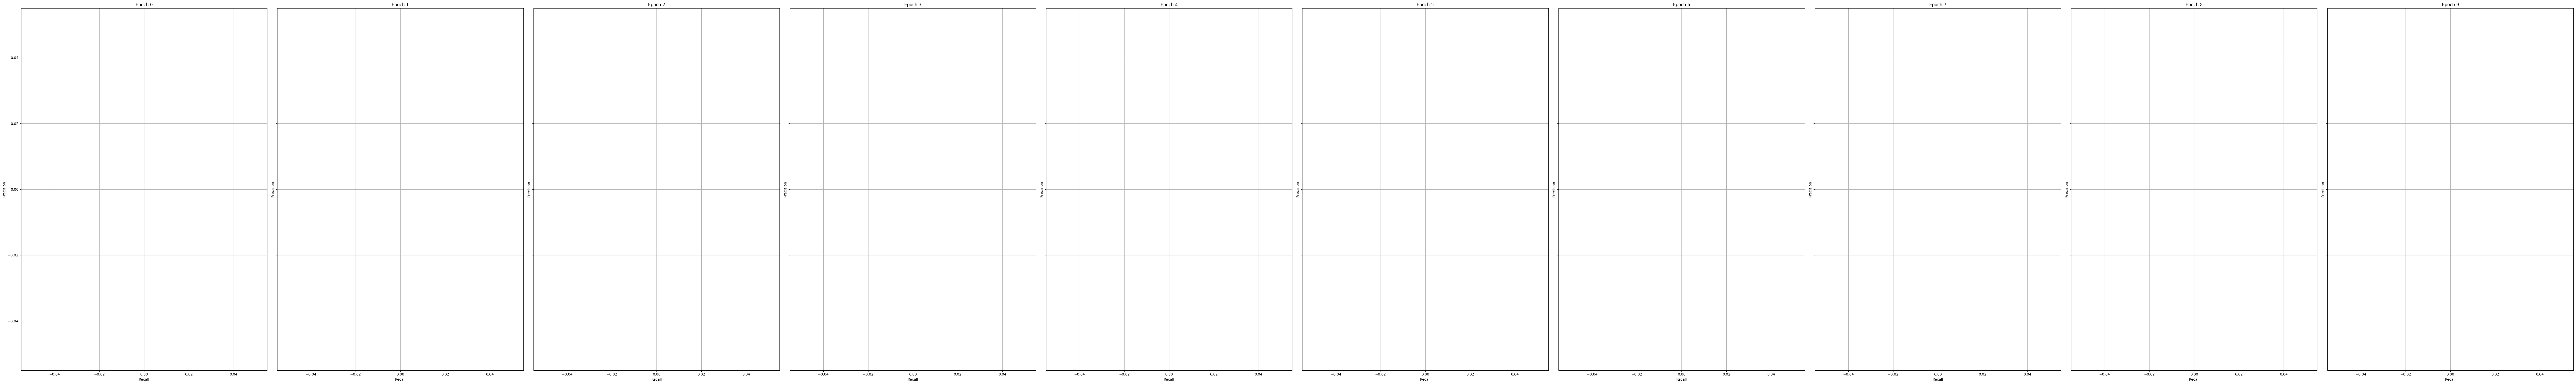

In [67]:
#true pos, false pos, true neg, false neg and weight

# Create a table of graphs with scatter plots for each epoch
num_points = clauses

# Loop through each epoch to create the graphs
fig, axs = plt.subplots(1, epochs, figsize=(10*epochs, 15), sharey=True)
fig.set_facecolor('white')

for epoch in range(epochs):
    recall = rec_prec[epoch, :, 0] / (rec_prec[epoch, :, 0] + rec_prec[epoch, :, 3])
    precision = rec_prec[epoch, :, 0] / (rec_prec[epoch, :, 0] + rec_prec[epoch, :, 1])
    x = rec_prec[epoch, :, 4]
    weight = rec_prec[epoch, :, -1]
    
    how_true = rec_prec[epoch, :, 0] + rec_prec[epoch, :, 2]
    how_fake = rec_prec[epoch, :, 1] + rec_prec[epoch, :, 3]

    # Create the scatter plot for the epoch
    axs[epoch].scatter(recall, precision, s=weight*50, cmap='Blues', label='Recall', marker='o')
    axs[epoch].set_title(f'Epoch {epoch}')
    axs[epoch].set_xlabel('Recall')
    axs[epoch].set_ylabel('Precision')
    axs[epoch].grid(True)
plt.tight_layout()
plt.show()


In [68]:
print(Y_test)
print(tm.predict(X_test))

[0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1]
[0 1 1 0 0 1 0 0 1 0 0 2 0 1 1 0 1 1 0 1]


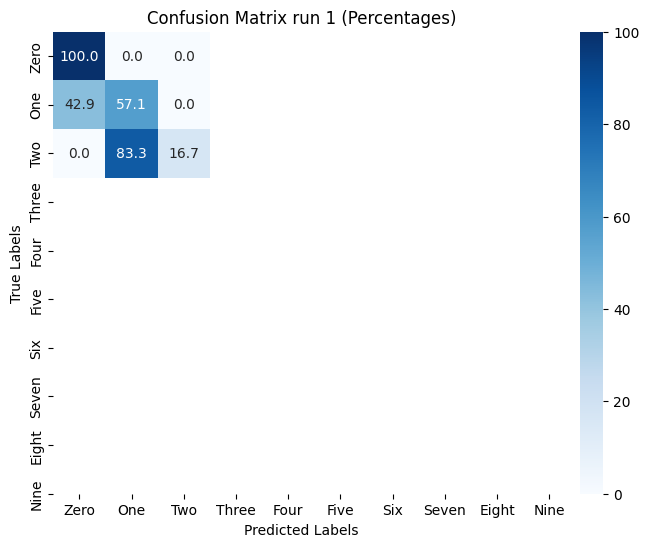

In [69]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percent = np.nan_to_num(conf_matrix_percent, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 1 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [70]:
#Plot Clause distribution
clause_appearances = np.zeros((tm.number_of_classes*tm.number_of_clauses))
clause_uniqueness = np.zeros(tm.number_of_clauses)
bank = tm.transform(X_train) # bank is a (image, clause*class) sized array
for image in range(bank.shape[0]):
    for clause in range(bank.shape[1]): #number of clauses here is class*clause
        Class = ((clause)//(clauses))
        if (Y_train[image] == Class) and (bank[image][clause]):
            clause_uniqueness[int(clause/tm.number_of_classes)] += 1
        else:
            clause_uniqueness[int(clause/tm.number_of_classes)] -= 1
        if bank[image][clause]: #note the appearances of clauses in image per class
            clause_appearances[int(clause/tm.number_of_classes)] +=1
            
print(tm.number_of_clauses)
print(tm.number_of_classes)
auxK = 0
""" 
for label in trained_labels:
    print("label", labels[label], "has", np.count_nonzero(Y_train==label), "images")
    auxK += np.count_nonzero(Y_train==label)
print("total images:", auxK)

print("clause_uniqueness.shape", clause_uniqueness.shape)
print("sort highest", np.sort(clause_uniqueness[:1500])[-15:].astype(int))
print("sort lowest", np.sort(clause_uniqueness[:])[:15].astype(int))

plt.hist(clause_uniqueness, bins=100) 
plt.xlabel('Uniqueness (-1 wrong class +1 right class)')
plt.ylabel('Appearances')
plt.title('Distinctive clauses distribution')
plt.show() """

6
3


' \nfor label in trained_labels:\n    print("label", labels[label], "has", np.count_nonzero(Y_train==label), "images")\n    auxK += np.count_nonzero(Y_train==label)\nprint("total images:", auxK)\n\nprint("clause_uniqueness.shape", clause_uniqueness.shape)\nprint("sort highest", np.sort(clause_uniqueness[:1500])[-15:].astype(int))\nprint("sort lowest", np.sort(clause_uniqueness[:])[:15].astype(int))\n\nplt.hist(clause_uniqueness, bins=100) \nplt.xlabel(\'Uniqueness (-1 wrong class +1 right class)\')\nplt.ylabel(\'Appearances\')\nplt.title(\'Distinctive clauses distribution\')\nplt.show() '

In [71]:
#Patch object
from matplotlib.gridspec import GridSpec

class Patch:
    def __init__(self, xMin, xMax, yMin, yMax, ID, patch_info, raw, weight=None):
        self.xMin = xMin
        self.xMax = xMax
        self.yMin = yMin
        self.yMax = yMax
        self.weight = weight
        self.ID = ID
        self.patch_info = patch_info
        self.raw = raw
        self.found_in_images = {}
        self.total_count = 0
        self.sparsity = 0
            
    def visualize_patch_info(self, polarity=0):
        # Rescale the channel values to the range of 0-255
        patch_info_scaled = (np.array(self.patch_info) * (255 / resolution)).astype(np.uint8)
        
        # Create an empty image canvas
        image = np.zeros((3, 3, 3), dtype=np.uint8)
        # Loop through each channel
        for c in range(3):
            image[:,:,c] = patch_info_scaled[:,:,c, polarity].reshape((3,3))
        
        return image
    def dominant_color(self, value=0):
        # Reshape the patch to a 9x3 array
        pixels = self.patch_info[...,0].reshape((9, 3))

        # Calculate the sum of color values for each channel
        color_sums = np.sum(pixels, axis=0)

        # Find the index of the channel with the highest sum
        dominant_channel = np.argmax(color_sums)

        # Determine the dominant color based on the channel index
        if dominant_channel == 0:
            dominant_color = 'R'
        elif dominant_channel == 1:
            dominant_color = 'G'
        else:
            dominant_color = 'B'
        
        if value == 1:
            return dominant_channel
        elif value == 2:
            return sum(self.patch_info[:,:,dominant_channel]) // 3
        else:
            return dominant_color
        
    def update_patch(self, image_id, location):
        print("SAD")
        if image_id in self.found_in_images:
            self.found_in_images[image_id].append(location)
        else:
            self.found_in_images[image_id] = [location]
        self.total_count += 1
        


def thermometer_to_integer(thermometer_bits, negated = 0):
    value = 0
    thermometer_bits_local = thermometer_bits
    length = len(thermometer_bits_local)
    for bit in range(length):
        if not negated:
            if thermometer_bits_local[bit]:
                value = bit+1
        else:
            if thermometer_bits_local[bit]:
                value = bit
                break
            value = length+1
    return value

bank = tm.transform(X_train) # bank is a (image, clause*class) sized array

def translate_block_of_bits(block, ID, resolution=8, patch_dim=(3,3), image_size=X_train_org.shape[1:3]):
    auxK = 0
    auxJ = image_size[0] - patch_dim[0] -1
    xMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] -1
    xMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    
    
    patch_info = np.zeros((3,3,3,2)) #sort out the pixels
    for column in range(3):
        # rows = []
        for row in range(3):
            # colors = []
            for color in range(3):
                start_bit = 58 + (column+row) * 24 + color * resolution
                end_bit = start_bit + resolution
                value = thermometer_to_integer(block[start_bit:end_bit])*(255/resolution)
                
                start_bit2 = 332 + (column+row) * 24 + color * resolution
                end_bit2 = start_bit2 + resolution
                value2 = thermometer_to_integer(block[start_bit2:end_bit2], negated=1)*(255/resolution)
                #value = (value + value2)/2
                #if value == 0: # turn the pixel white if empty
                #    value = 8
                patch_info[column,row,color,0] = value
                patch_info[column,row,color,1] = value2
                # colors.append(value)
            # rows.append(colors)
        # patch_info.append(rows)
    raw = block
    weight = 0
    ID = ID
    return Patch(xMin=xMin, xMax=xMax, yMin=yMin, yMax=yMax, weight=weight, ID=ID, patch_info=patch_info, raw=raw)



Highlighting for image 3 of class Zero
Class 0 Zero
Pro clauses for Class 0: [0, 1]
Against clauses for Class 0: [3]


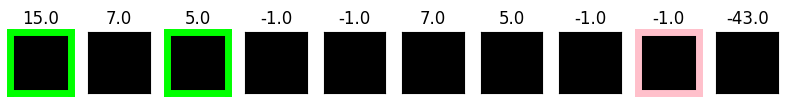

Class 1 One
Pro clauses for Class 1: [0, 1, 6, 7]
Against clauses for Class 1: [3, 10]


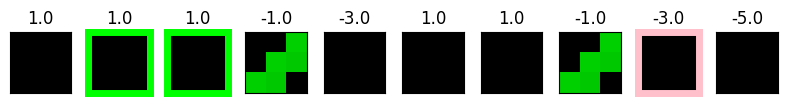

Class 2 Two
Pro clauses for Class 2: [0, 1, 6, 7, 12]
Against clauses for Class 2: [3, 10, 15, 17]


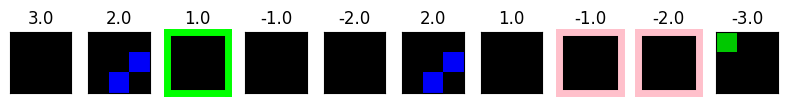

In [72]:
#Weighted Patches list

#show how many patches
n_extreme_patches = 5
highlight_colors = {
    "for": "lime",
    "against": "pink"
}

highlight = True
check_image = 3

print("Highlighting for image", check_image, "of class", labels[Y_train_org[check_image]])

pro_clauses = []
against_clauses = []
all_patches = [] #class, clause

# Populate the patches list
k=0 # ID
for Class in range(tm.number_of_classes):
    class_patches = []
    for Clause in range(tm.number_of_clauses):
        block = [tm.get_ta_action(Clause, bit, Class) for bit in range(576)]
        class_patches.append(translate_block_of_bits(block, k))
        k += 1
    all_patches.append(class_patches)

# Select top clauses
highest_indices = np.zeros((tm.number_of_classes, n_extreme_patches))
lowest_indices  = np.zeros((tm.number_of_classes, n_extreme_patches))
weights_sorted_indices = np.zeros((tm.number_of_classes, tm.number_of_clauses))
all_weights = np.zeros((tm.number_of_classes, tm.number_of_clauses))

for Class in range(tm.number_of_classes):
    for clause in range(tm.number_of_clauses):
        all_weights[Class, clause] = (tm.get_weight(the_class=Class,clause=clause,polarity=0))
    weights_sorted_indices[Class] = all_weights[Class].argsort()
    highest_indices[Class] = weights_sorted_indices[Class][-n_extreme_patches:].astype(int)
    lowest_indices[Class]  = weights_sorted_indices[Class][:n_extreme_patches].astype(int)

# Assign lowest and highest weighted patches to the indices  
extreme_patches = np.zeros((tm.number_of_classes,2,n_extreme_patches), dtype=Patch)
extreme_weights = np.zeros((tm.number_of_classes,2,n_extreme_patches), dtype=np.int16)
    
for Class in range(tm.number_of_classes):
    print("Class", Class, labels[Class])
    polarity = 0
    for i, k in enumerate(lowest_indices[Class].astype(int)):
        all_patches[Class][np.min((k, 997))].weight = all_weights[Class][np.min((k, 997))]
        extreme_patches[Class, polarity, i] = all_patches[Class][np.min((k, 997))]
        
    polarity = 1
    for i, k in enumerate(highest_indices[Class].astype(int)):
        all_patches[Class][k].weight = all_weights[Class][k]
        extreme_patches[Class, polarity, i] = all_patches[Class][k]


    extreme_patches = np.flip(extreme_patches,2)
    extreme_weights = np.flip(extreme_weights,2)
    
    # Assign Pro and Against clauses per class
    for clause in range(int(tm.number_of_clauses/2)):  # First half for pro_clauses
        if bank[check_image][clause + Class * tm.number_of_clauses]:  # If the clause is activated
            pro_clauses.append(clause + Class * tm.number_of_clauses)
    for clause in range(int(tm.number_of_clauses/2), tm.number_of_clauses):  # Second half for against_clauses
        if bank[check_image][clause + Class * tm.number_of_clauses]:  # If the clause is activated
            against_clauses.append(clause + Class * tm.number_of_clauses)
    print(f"Pro clauses for Class {Class}: {pro_clauses}")
    print(f"Against clauses for Class {Class}: {against_clauses}")



    #Print patches grid
    num_rows = 10
    num_cols = 10

    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(num_rows, num_cols)
    adjusted_index = 0
    for patch_index in range(0, n_extreme_patches*2):
        if (patch_index >= n_extreme_patches): 
            polarity = 0
            adjusted_index = patch_index - n_extreme_patches
        else:
            adjusted_index = patch_index
            polarity = 1
        ax = fig.add_subplot(gs[patch_index // num_cols, patch_index % num_cols])
        ax.imshow(extreme_patches[Class, polarity, adjusted_index].visualize_patch_info())
        
        if highlight:
            # Highlight the randomly selected patches
            if polarity == 1 and extreme_patches[Class, polarity, adjusted_index].ID in pro_clauses:
                for spine in ax.spines.values():
                    spine.set_edgecolor(highlight_colors["for"])
                    spine.set_linewidth(5)
            elif polarity == 0 and extreme_patches[Class, polarity, adjusted_index].ID in against_clauses:
                for spine in ax.spines.values():
                    spine.set_edgecolor(highlight_colors["against"])
                    spine.set_linewidth(5)
            
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
        ax.set_title((extreme_weights[Class][polarity][adjusted_index]).astype(str) + " " + (extreme_patches[Class, polarity, adjusted_index]).dominant_color())
        ax.set_title(extreme_patches[Class, polarity, adjusted_index].weight.astype(str))

    
    plt.tight_layout()
    plt.show()

In [73]:
import math 
def find_patches_in_image(image, patches_to_search, targeted_search=False, avg=True):
    """
    Search for specific patches within a given image. Return found ID and coordinates.
    
    Parameters:
    - image: 2D array representing the image.
    - patches_to_search: List of Patch objects to search for in the image.
    - targeted_search: Boolean indicating whether to search only within the patch's expected coordinates.
    - avg: Boolean indicating whether to return average coordinates for each patch.
    
    Returns:
    - results: Array with shape (number of patches, 3) containing the patch ID and its (average) x and y coordinates.
    - found_coordinates: List of tuples containing the coordinates where patches were found.
    """
    results = []
    for patch in patches_to_search:
        patch_info = patch.patch_info
        
        # Define the search area based on the targeted_search flag
        if targeted_search:
            search_area = image[patch.xMin:patch.xMax, patch.yMin:patch.yMax]
            offset_x, offset_y = patch.xMin, patch.yMin
        else:
            search_area = image
            offset_x, offset_y = 0, 0
        
        found_coordinates = []
        for x in range(search_area.shape[0] - patch_info.shape[0] + 1):
            for y in range(search_area.shape[1] - patch_info.shape[1] + 1):
                region = search_area[x:x+patch_info.shape[0], y:y+patch_info.shape[1]]
                if np.all(region >= patch_info[...,0]) and np.all(region <= patch_info[...,1]):
                    found_coordinates.append((x + offset_x, y + offset_y))
        
        # Calculate average coordinates if required
        if avg and found_coordinates:
            avg_x = int(np.mean([coord[0] for coord in found_coordinates]))
            avg_y = int(np.mean([coord[1] for coord in found_coordinates]))
            results.append((patch.ID, avg_x, avg_y))
        elif not avg:
            results.append((patch.ID, found_coordinates))
    
    return results


""" 
def find_patches_in_images(images, labels, patches_to_find, targeted_search=False, avg=False):
    
    results = []
    
    for i in range(patches_to_find.shape[0]):
        print(i)
        k = find_patches_in_image(images[i], patches_to_find[labels[i], 0, :], targeted_search=targeted_search, avg=avg)
        results.append(k)
        patches_to_find[labels[i], 0, :].update_patch(i,k)
    
    return results  # Return the list of arrays directly
 """

def find_patches_in_images(images, labels, patches_to_find):

    num_images = len(images)
    valid_indices = np.where((labels < patches_to_find.shape[0]) & (labels < num_images))[0]
    
    results = [find_patches_in_image(images[i], patches_to_find[labels[i], 0, :], targeted_search=True) for i in tqdm(valid_indices, desc="Processing images", position=0, leave=True)]
    
    return results  # Return the list of arrays directly

def get_patch_counts(all_results, labels):
    """
    Count the occurrences of each patch within the results.
    
    Parameters:
    - all_results: Array containing the results of the patch search. [ID, X, Y]
    - labels: List of labels corresponding to each image.
    
    Returns:
    - patch_counts: Array containing the counts of each patch.
    """
    all_patch_ids = np.unique(all_results[..., 0])
    print(all_patch_ids)
    patch_counts = np.zeros((tm.number_of_classes, len(all_patch_ids), 2))  # [class, patch_id, count]
    
    for idx, patch_list in enumerate(all_results):
        class_label = labels[idx]
        for result in patch_list:
            if result[1] != -1:
                patch_idx = np.where(all_patch_ids == result[0])[0][0]
                patch_counts[class_label, patch_idx, 0] += 1
                patch_counts[class_label, patch_idx, 1] = idx  # storing last image index; can be adapted for multiple indices
    
    return patch_counts

def get_frequent_patches(patch_counts, labels, threshold=0.8):
    """
    Identify patches that appear frequently.
    
    Parameters:
    - patch_counts: Array containing the counts of each patch.
    - labels: List of labels corresponding to each image.
    - threshold: Minimum frequency for a patch to be considered frequent.
    
    Returns:
    - result_array: Array containing the frequent patches.
    """
    # 1. Pre-allocate an array with maximum possible dimensions.
    result_array = np.full((patch_counts.shape[0], patch_counts.shape[1] + 1), -1)
    
    # 2. Use a separate counter to keep track of how many rows have been filled.
    row_counter = 0
    for counts in patch_counts:
        freq_indices = np.where(counts[:, 0] >= threshold * np.sum(labels == row_counter))[0]
        
        # Add the class index and the frequent patch indices to the pre-allocated array.
        result_array[row_counter, 0] = row_counter  # Store the class index
        result_array[row_counter, 1:1+len(freq_indices)] = freq_indices
        
        # Update the counter.
        row_counter += 1
    
    # 3. After the loop, slice the array to remove any unfilled rows.
    result_array = result_array[result_array[:, 0] != -1]
    
    return result_array

def get_origin_patches(patch_counts, all_results, how_many=2):
    """
    Identify the top patches for each class based on their counts and retrieve all their appearances in each image.
    
    Parameters:
    - patch_counts: Array containing the counts of each patch.
    - all_results: Array containing the results of the patch search.
    - how_many: Number of top patches to identify.
    
    Returns:
    - Array containing the coordinates of the top patches for each image and class.
    """
    num_images = len(all_results)
    num_classes = len(patch_counts)
    
    # Initialize the array to store the coordinates
    origin_coords = np.full((num_images, num_classes, how_many, 2), -1)  # Using -1 to indicate "not found"
    
    for class_idx, counts in enumerate(patch_counts):
        # Get the indices of the top patches for this class
        top_patches = np.argsort(counts[:, 0])[::-1][:how_many]
        
        for image_idx, results in enumerate(all_results):
            for patch_idx, top_patch in enumerate(top_patches):
                # Check if the current top patch is in the results for this image
                matching_indices = np.where(results[:, 0] == top_patch)[0]
                
                if matching_indices.size > 0:
                    # Store all the coordinates of this patch for this image
                    origin_coords[image_idx, class_idx, patch_idx] = results[matching_indices[0], 1:3]
                    
    return origin_coords

def encode_origin(images, Y_images, origin_points, n_origin_points=2):
    """
    Encode images based on the distance and angle to the origin patch.
    
    Parameters:
    - images: List of 2D arrays representing the images.
    - Y_images: List of labels corresponding to each image.
    - origin_points: List of origin points.
    - n_origin_points: Number of origin points to consider.
    
    Returns:
    - encoded_patches: Array containing the encoded images.
    """
    batch_size, height, width, _ = images.shape
    encoded_patches = np.empty((batch_size, height, width, 2 * n_origin_points))

    for i in range(batch_size):
        class_label = Y_images[i, 0] if len(Y_images.shape) > 1 else Y_images[i] #TODO: sometimes its two dim array??
        if class_label < tm.number_of_classes:
            origins = origin_points[class_label]  # Adjusted to get origins for specific image and class
        else:
            encoded_patches[i] = np.zeros((height, width, 2 * n_origin_points))
            continue
        
        for point in range(n_origin_points):
            print(i)
            origin_coord = origins[i]
            
            # Check if the origin coordinate is a placeholder
            if np.any(origin_coord == -1):
                continue
            for j in range(height):
                for k in range(width):
                    distance, angle = calculate_distance_and_angle(origin_coord, (j, k))
                    encoded_patches[i, j, k, point*2:point*2+2] = [distance, angle]
            
    return encoded_patches


def scale_value_int(value, old_max, new_max):
    return int((value / old_max) * new_max)

def get_patch_coordinates(all_results, frequent_patches):
    """
    Get the coordinates of the frequent patches.
    
    Parameters:
    - all_results: Array containing the results of the patch search.
    - frequent_patches: List of frequent patches.
    
    Returns:
    - coords: Array containing the coordinates of the frequent patches.
    """
    # Create a mapping from patch_id to a unique index
    unique_patch_ids = np.unique(all_results[..., 0])
    patch_id_to_index = {patch_id: idx for idx, patch_id in enumerate(unique_patch_ids)}
    
    coords = np.empty((len(frequent_patches), len(unique_patch_ids), 2))
    
    for row in frequent_patches:
        patches = row[1:][row[1:] != -1]  # filter out the -1 placeholders
        
        for patch_id in patches:
            indices = np.where(all_results[..., 0] == patch_id)[0]
            if indices.size > 0:
                # Use the mapping to get the index for this patch_id
                idx = patch_id_to_index[patch_id]
                coords[row[0], idx] = all_results[indices[0], 1:3, :2].mean(axis=0)
            
    return coords

def calculate_distance_and_angle(coord1, coord2):
    #TODO: remove the koeficients and replace with variable adjusting. the scaling now is to fit 0 to 255 scale
    distance = 7* math.sqrt((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1])**2)
    angle = 80 * math.atan2(coord2[1] - coord1[1], coord2[0] - coord1[0])
    return distance, angle



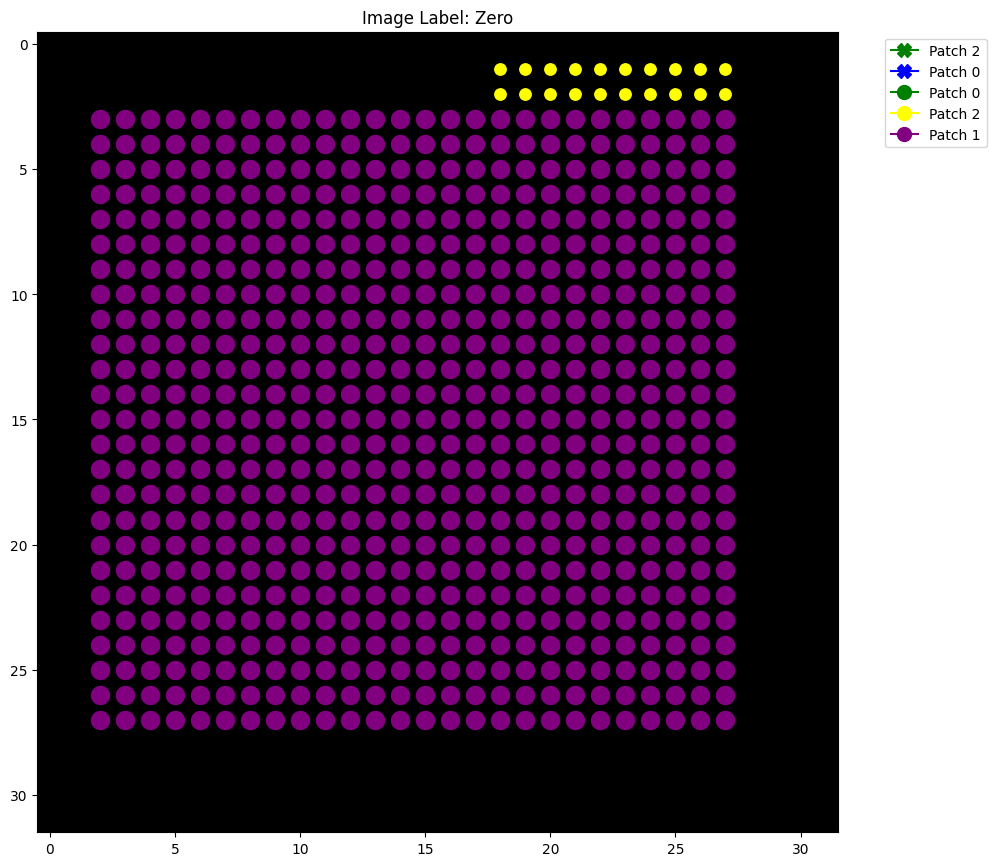

Minimum values of patches


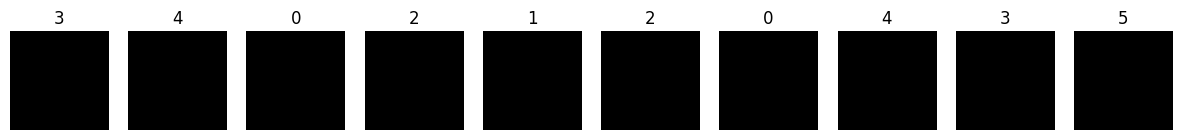

Maximum values of patches


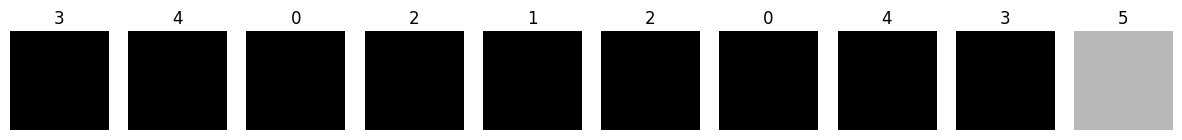

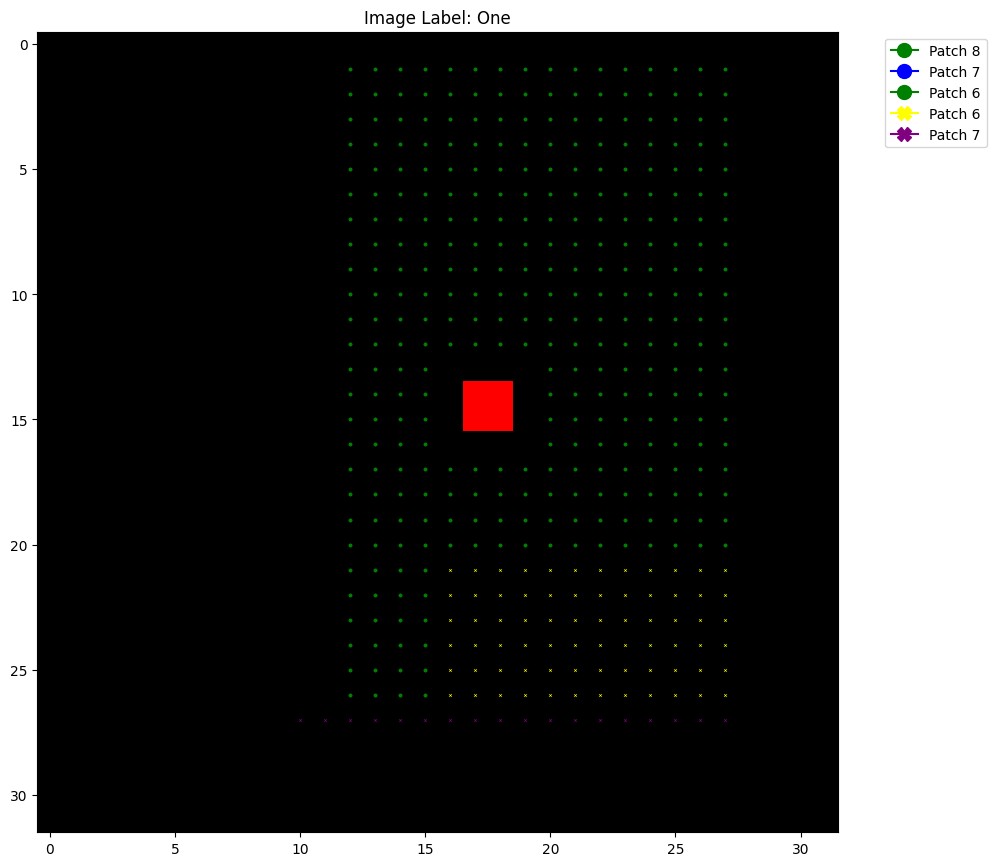

Minimum values of patches


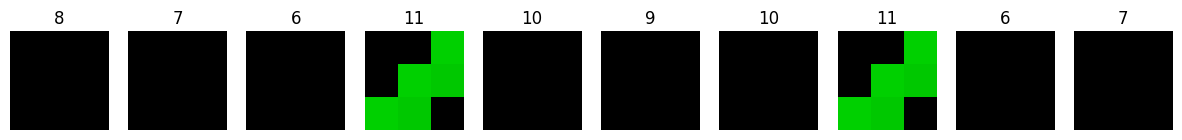

Maximum values of patches


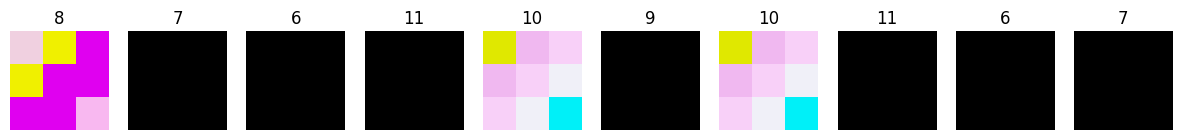

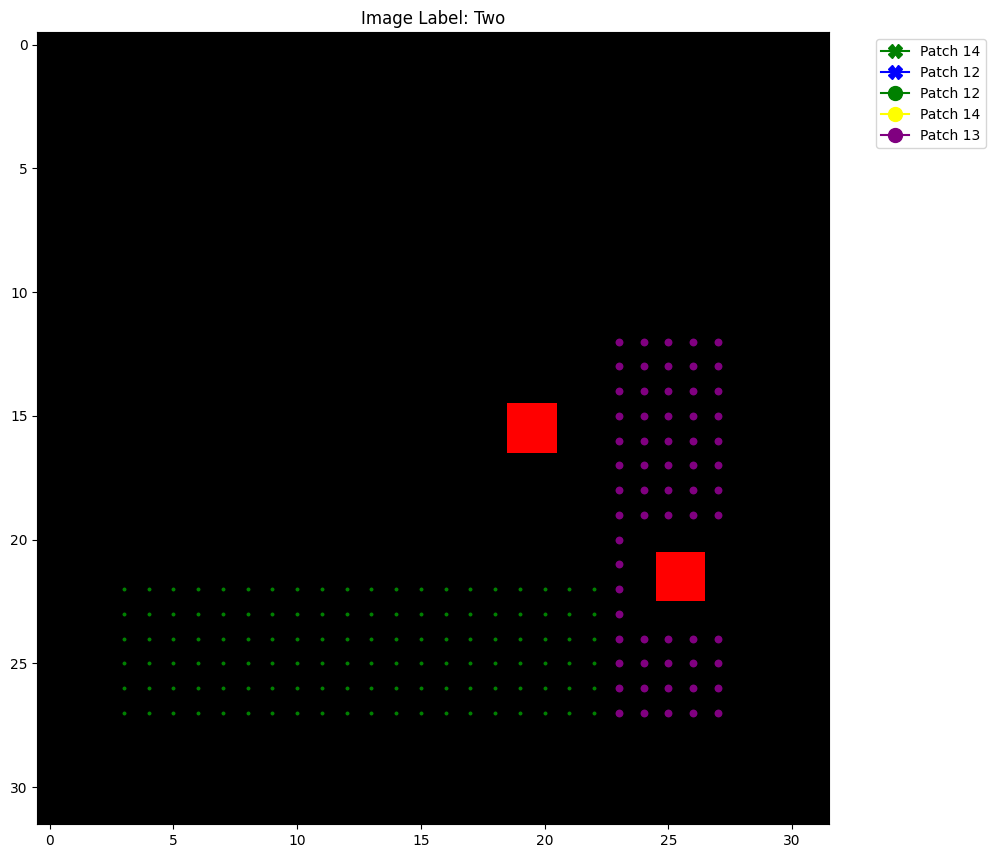

Minimum values of patches


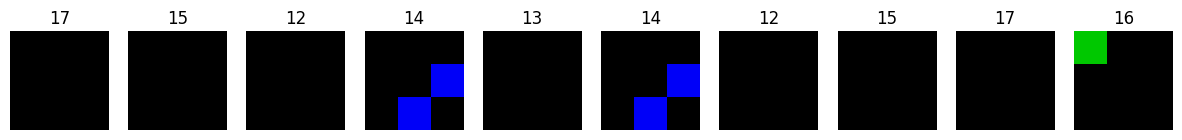

Maximum values of patches


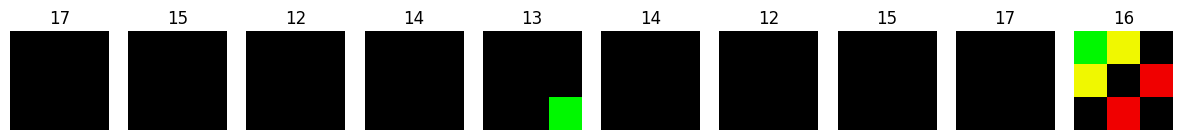

In [74]:
#Plot extreme patches on images

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_patches_in_images(patch_list_pos, patch_list_neg, images, image_labels):
    all_results = {}
    
    # Define a list of colors
    colors = ['green', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink']
    
    for img_index, (image, label) in enumerate(zip(images, image_labels)):
        results = []
        legend_elements = []  # List to hold the legend elements
        heatmaps = np.zeros_like(image, dtype=float)

        # Plot the main image with dots
        fig_main, ax_main = plt.subplots(figsize=(10, 10))
        ax_main.imshow(image, cmap='gray')
        ax_main.set_title(f'Image Label: {label}')

        for patch_idx, (patch_pos, patch_neg) in enumerate(zip(patch_list_pos, patch_list_neg)):
            patch = patch_pos if patch_pos.weight > 0 else patch_neg
            marker_style = 'o' if patch_pos.weight > 0 else 'X'
            
            # Use the new find_patches_in_image function
            patch_search_results = find_patches_in_image(image, [patch], targeted_search=True, avg=False)
            
            color = colors[patch_idx % len(colors)]
            for patch_id, patch_coords in patch_search_results:
                for coord in patch_coords:
                    # Plot the position with the chosen marker style
                    ax_main.scatter(coord[1]+1, coord[0]+1, color=color, s=abs(patch.weight*15), marker=marker_style, edgecolors='black', linewidths=1)
                    results.append((patch_id, coord[0], coord[1]))
            
            # Add a legend element for each patch
            legend_elements.append(Line2D([0], [0], marker=marker_style, color=color, label=f'Patch {patch.ID}', markersize=10, markerfacecolor=color, markeredgewidth=1))

        # Add the legend outside of the main plot
        ax_main.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print("Minimum values of patches")
        # Plot each patch in a separate figure
        fig_patches, axs = plt.subplots(1, len(patch_list_pos) + len(patch_list_neg), figsize=(15, 3))
        if len(patch_list_pos) + len(patch_list_neg) == 1:
            axs = [axs]

        for patch_idx, patch in enumerate(patch_list_pos + patch_list_neg):
            patch_image = patch.visualize_patch_info()  # Visualize the patch
            axs[patch_idx].imshow(patch_image)
            axs[patch_idx].set_title(f'{patch.ID}')
            axs[patch_idx].axis('off')  # Hide the axis

        plt.show()
        print("Maximum values of patches")
        # Plot each patch in a separate figure
        fig_patches, axs = plt.subplots(1, len(patch_list_pos) + len(patch_list_neg), figsize=(15, 3))
        if len(patch_list_pos) + len(patch_list_neg) == 1:
            axs = [axs]

        for patch_idx, patch in enumerate(patch_list_pos + patch_list_neg):
            patch_image = patch.visualize_patch_info(polarity=1)  # Visualize the patch
            axs[patch_idx].imshow(patch_image)
            axs[patch_idx].set_title(f'{patch.ID}')
            #axs[patch_idx].set_title(f'{patch.weight}')
            axs[patch_idx].axis('off')  # Hide the axis
 
        plt.show()

        all_results[img_index] = results
    
    return all_results




for index, image in enumerate(X_test_org[0:len(trained_labels)]):
    # Example usage: extreme_patches[Class, polarity, adjusted_index]
    patches_to_search_pos = [extreme_patches[Y_test_org[index]][1][n_extreme_patches-k-1] for k in range(5)]
    patches_to_search_neg = [extreme_patches[Y_test_org[index]][0][k] for k in range(5)]
    show_results = plot_patches_in_images(patches_to_search_pos, patches_to_search_neg, [image], [labels[Y_test_org[index]]])

In [75]:
for i in range(5):
    print(extreme_patches[1][1][i].found_in_images)
    print(extreme_patches[0][1][i].total_count)
print(extreme_patches.shape)

{}
0
{}
0
{}
0
{}
0
{}
0
(3, 2, 5)


In [76]:

def get_5x5_binary_mask(image, patch, all_detected_patches):
    """
    For the given patch in the image, this function checks a 5x5 region around it
    to see if the same patch appears in any of the positions. Returns a 5x5 binary mask.
    """
    
    mask = np.zeros((5, 5), dtype=bool)
    patch_info = patch.patch_info
    patch_size = patch_info.shape[0]  # Assuming patches are square (3x3)
    center_offset = patch_size // 2  # Offset from the patch's top-left to its center
    
    # Check each position in the 5x5 region
    for i in range(5):
        for j in range(5):
            x_offset = i - 2  # -2 to account for the center of the 5x5 mask
            y_offset = j - 2  # Same as above
            
            # Check the coordinates for this offset
            x_center = patch.x + center_offset + x_offset
            y_center = patch.y + center_offset + y_offset
            
            # Check if there's a detected patch around these coordinates
            for detected_patch in all_detected_patches:
                if (abs(detected_patch.x - x_center) <= center_offset) and (abs(detected_patch.y - y_center) <= center_offset):
                    mask[i, j] = True
                    break
                    
    return mask

def get_masks_for_all_patches(image, patches_to_search):
    all_detected_patches = find_patches_in_image(image, patches_to_search)
    masks = {}
    for patch in all_detected_patches:
        masks[patch.ID] = get_5x5_binary_mask(image, patch, all_detected_patches)
    return masks

""" # Example Usage
image = X_test_org[0]
example_masks = get_masks_for_all_patches(image, extreme_patches[Y_test_org[0], 0, :])

# Displaying the masks for visualization
for patch_id, mask in example_masks.items():
    plt.imshow(mask, cmap="gray")
    plt.title(f"5x5 Mask for Patch {patch_id}")
    plt.show() """

' # Example Usage\nimage = X_test_org[0]\nexample_masks = get_masks_for_all_patches(image, extreme_patches[Y_test_org[0], 0, :])\n\n# Displaying the masks for visualization\nfor patch_id, mask in example_masks.items():\n    plt.imshow(mask, cmap="gray")\n    plt.title(f"5x5 Mask for Patch {patch_id}")\n    plt.show() '

In [77]:
extreme_patches.shape

(3, 2, 5)

In [78]:
print("Finding patches in images...")
X_test_all_results = find_patches_in_images(X_test_org, Y_test_org, extreme_patches)
X_train_all_results = find_patches_in_images(X_train_org, Y_train_org, extreme_patches)
print ("Counting patches...")
#X_test_patch_counts = get_patch_counts(X_test_all_results, Y_test_org)
"""print("Identifying frequent patches...")
X_test_frequent_patches = get_frequent_patches(X_test_patch_counts, Y_test_org)
print("Identifying origin patches IDs...")
X_test_origin_patches = get_origin_patches(X_test_patch_counts, X_test_all_results)
print("Getting patch coordinates...")
X_test_patch_coordinates = get_patch_coordinates(X_test_all_results, X_test_frequent_patches) """

Finding patches in images...


Processing images: 100%|██████████| 100/100 [00:00<00:00, 383.59it/s]

Counting patches...


'print("Identifying frequent patches...")\nX_test_frequent_patches = get_frequent_patches(X_test_patch_counts, Y_test_org)\nprint("Identifying origin patches...")\nX_test_origin_patches = get_origin_patches(X_test_patch_counts)\nprint("Getting patch coordinates...")\nX_test_patch_coordinates = get_patch_coordinates(X_test_all_results, X_test_frequent_patches) '

In [79]:
""" counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_test_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1
print(counts)
anchors_id = []
#get anchor points
for Class in range(tm.number_of_classes):
    #sort per class, args are IDs, get two most common
    anchors_id.append(counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:])
print("anchors_id", anchors_id) #[Class, IDs of anchors]
coords =[]
for image in X_test_all_results:
    for result in image:
        print(result)
        print("a", anchors_id[0])
        if result[0] == anchors_id[0] or result[0] == anchors_id[1]: 
            coords = result 
print("coords:", coords)

encode_origin(X_test_org, Y_test_org, anchors_id, 2) #???? """

' counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))\nfor image_results in X_test_all_results:\n    for patch in image_results:\n        patch_id = patch[0]\n        counts[patch_id] += 1\nprint(counts)\nanchors_id = []\n#get anchor points\nfor Class in range(tm.number_of_classes):\n    #sort per class, args are IDs, get two most common\n    anchors_id.append(counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:])\nprint("anchors_id", anchors_id) #[Class, IDs of anchors]\ncoords =[]\nfor image in X_test_all_results:\n    for result in image:\n        print(result)\n        print("a", anchors_id[0])\n        if result[0] == anchors_id[0] or result[0] == anchors_id[1]: \n            coords = result \nprint("coords:", coords)\n\nencode_origin(X_test_org, Y_test_org, anchors_id, 2) #???? '

In [80]:
#find anchors on test data
counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_test_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1

# Initialize origin_points
origin_points = [[] for _ in range(tm.number_of_classes)]
# Get anchor points for each class
for Class in range(tm.number_of_classes):
    # Sort per class, args are IDs, get two most common
    anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
    #IDs now per class
    for anchor_id in anchor_ids: #per ID
        # Find the coordinates of the anchor patches
        for image_results in X_test_all_results: 
            for result in image_results:
                if result[0] == anchor_id:
                    origin_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                else:
                    origin_points[Class].append([0,0]) 

# Now pass this to the encode_origin function
encoded_patches_test = encode_origin(X_test_org, Y_test_org, origin_points, 2)


0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19


In [81]:
#find anchors on train data
counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_train_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1
anchors_id = []

# Initialize origin_points
origin_points = [[] for _ in range(tm.number_of_classes)]
# Get anchor points for each class
for Class in range(tm.number_of_classes):
    # Sort per class, args are IDs, get two most common
    anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
    #IDs now per class
    for anchor_id in anchor_ids: #per ID
        # Find the coordinates of the anchor patches
        for image_results in X_test_all_results: 
            for result in image_results:
                if result[0] == anchor_id:
                    origin_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                else:
                    origin_points[Class].append([0,0]) 

# Now pass this to the encode_origin function
encoded_patches_train = encode_origin(X_train_org, Y_train_org, origin_points, 2)


0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99


In [82]:
print(thermometer_encode(encoded_patches_test,prevMax=33)[0, 0, 1])

[[1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1]]


In [83]:

# Create the windowed datasets
X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_train_org), thermometer_encode(encoded_patches_train), patch_dim=patch_dim)
X_test,  dataset_dimensions = create_windowed_dataset(thermometer_encode(X_test_org), thermometer_encode(encoded_patches_test), patch_dim=patch_dim)



In [84]:
#Train the TM and record results
f = open("cifar2_%.1f_%d_%d_%d_%d_%d_withoutSS Gradient.txt" % (s, clauses, T, step, visual_tokens, scaling), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        if visual_tokens:
                tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        else:
                tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(3,3), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label
                
                number_of_includes = 0
                for i in range(2):
                        for j in range(clauses):
                                number_of_includes += tm.number_of_include_actions(i, j)
                number_of_includes /= 2*clauses

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                f.flush()
f.close()



Training:
3 labels used: [0 1 2]
Training pictures: 100
Testing:
3 labels used: [0 1 2]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 20

Accuracy over 10 epochs:



  0%|          | 0/10 [00:00<?, ?it/s]

2023-11-17 15:13:48,315 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 10%|█         | 1/10 [00:01<00:09,  1.07s/it]

0 0 60.33 25.00 40.00 0.18 0.15


 20%|██        | 2/10 [00:01<00:07,  1.02it/s]

0 1 156.83 45.00 45.00 0.02 0.15


 30%|███       | 3/10 [00:02<00:06,  1.05it/s]

0 2 266.25 40.00 44.00 0.02 0.15


 40%|████      | 4/10 [00:03<00:05,  1.07it/s]

0 3 287.00 50.00 54.00 0.02 0.15


 50%|█████     | 5/10 [00:04<00:04,  1.08it/s]

0 4 280.75 55.00 61.00 0.02 0.15


 60%|██████    | 6/10 [00:05<00:03,  1.09it/s]

0 5 333.42 45.00 41.00 0.02 0.15


 70%|███████   | 7/10 [00:06<00:02,  1.09it/s]

0 6 316.42 45.00 49.00 0.02 0.15


 80%|████████  | 8/10 [00:07<00:01,  1.10it/s]

0 7 282.42 40.00 44.00 0.02 0.15


 90%|█████████ | 9/10 [00:08<00:00,  1.10it/s]

0 8 319.33 55.00 61.00 0.02 0.15


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


0 9 366.92 60.00 61.00 0.02 0.15

Accuracy over 10 epochs:



  0%|          | 0/10 [00:00<?, ?it/s]

2023-11-17 15:13:57,565 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

1 0 70.17 70.00 72.00 0.16 0.14


 20%|██        | 2/10 [00:01<00:07,  1.06it/s]

1 1 122.92 45.00 41.00 0.02 0.15


 30%|███       | 3/10 [00:02<00:06,  1.09it/s]

1 2 108.17 60.00 49.00 0.02 0.15


 40%|████      | 4/10 [00:03<00:05,  1.10it/s]

1 3 179.33 40.00 44.00 0.02 0.15


 50%|█████     | 5/10 [00:04<00:04,  1.11it/s]

1 4 160.25 40.00 43.00 0.02 0.15


 60%|██████    | 6/10 [00:05<00:03,  1.11it/s]

1 5 218.42 35.00 33.00 0.02 0.15


 70%|███████   | 7/10 [00:06<00:02,  1.11it/s]

1 6 207.83 40.00 44.00 0.02 0.15


 80%|████████  | 8/10 [00:07<00:01,  1.11it/s]

1 7 212.33 65.00 53.00 0.02 0.15


 90%|█████████ | 9/10 [00:08<00:00,  1.11it/s]

1 8 220.17 70.00 68.00 0.02 0.15


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


1 9 251.33 75.00 73.00 0.02 0.15

Accuracy over 10 epochs:



  0%|          | 0/10 [00:00<?, ?it/s]

2023-11-17 15:14:06,654 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

2 0 63.08 30.00 33.00 0.16 0.14


 20%|██        | 2/10 [00:01<00:07,  1.05it/s]

2 1 72.25 40.00 42.00 0.02 0.15


 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

2 2 95.17 65.00 65.00 0.02 0.15


 40%|████      | 4/10 [00:03<00:05,  1.08it/s]

2 3 140.67 70.00 64.00 0.02 0.15


 50%|█████     | 5/10 [00:04<00:04,  1.09it/s]

2 4 172.75 75.00 69.00 0.02 0.15


 60%|██████    | 6/10 [00:05<00:03,  1.10it/s]

2 5 230.50 60.00 64.00 0.02 0.15


 70%|███████   | 7/10 [00:06<00:02,  1.10it/s]

2 6 226.83 70.00 73.00 0.02 0.15


 80%|████████  | 8/10 [00:07<00:01,  1.09it/s]

2 7 200.50 40.00 44.00 0.02 0.15


 90%|█████████ | 9/10 [00:08<00:00,  1.10it/s]

2 8 172.67 75.00 74.00 0.02 0.15


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

2 9 213.75 70.00 76.00 0.02 0.15


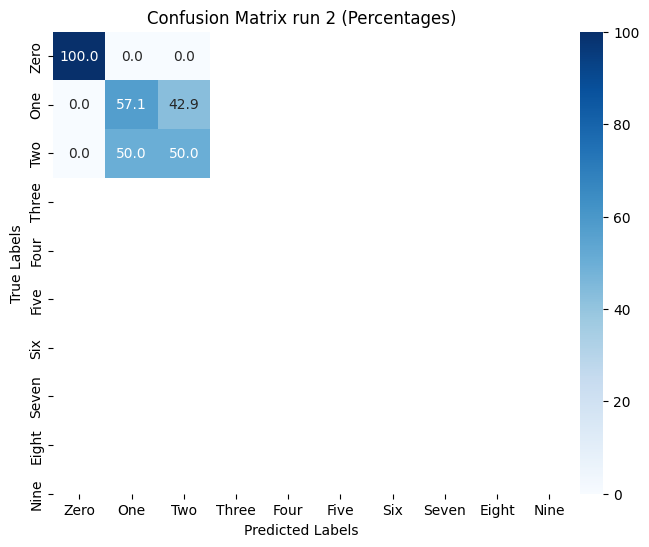

In [85]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percent = np.nan_to_num(conf_matrix_percent, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 2 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [86]:
print("Finding patches in images...")
X_train_all_results = find_patches_in_images(X_train_org, Y_train_org, extreme_patches)
print("Counting patches...")
X_train_patch_counts = get_patch_counts(X_train_all_results, Y_train_org)
print("Identifying frequent patches...")


Finding patches in images...


Processing images: 100%|██████████| 100/100 [00:00<00:00, 393.44it/s]

Counting patches...


TypeError: get_patch_counts() takes 2 positional arguments but 3 were given

In [ ]:
X_train_frequent_patches = get_frequent_patches(X_train_patch_counts, Y_train_org, threshold=0.8)
print("Identifying origin patches IDs...")
X_train_origin_patches = get_origin_patches(X_train_patch_counts,X_train_all_results)
print("Getting patch coordinates...")
X_train_patch_coordinates = get_patch_coordinates(X_train_all_results, X_train_frequent_patches)

Identifying origin patches IDs...
Getting patch coordinates...


In [ ]:
print(X_train_patch_coordinates)

{0: {102: [(7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7)], 114: [(7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7)

In [ ]:

# go through origin patches per image's class, mark their relative distances
X_test_relative_positions_list = []

for idx, class_label in tqdm(enumerate(Y_test)):
    if not class_label < tm.number_of_classes:
        continue
    origin1_id, origin2_id = X_test_origin_patches[class_label]
    origin1_coord = X_test_patch_coordinates[class_label][origin1_id][0]
    origin2_coord = X_test_patch_coordinates[class_label][origin2_id][0]
    X_test_origin_coor = [origin1_coord, origin2_coord]
    X_test_relative_positions_list.append(encode_origin(np.array([X_test_org[idx]]), np.array([Y_test_org[idx]]), [X_test_origin_coor]))

X_test_relative_positions = np.vstack(X_test_relative_positions_list)

In [ ]:
class_label = 1
origin1_id, origin2_id = X_train_origin_patches[class_label]
origin1_coord = X_train_patch_coordinates[class_label][origin1_id][0]  # Assuming the first coordinate is the one you want
origin2_coord = X_train_patch_coordinates[class_label][origin1_id][1]  # Same assumption here
X_train_origin_coor = origin1_coord

print(X_train_origin_coor)


(13, 4)


In [ ]:
# go through origin patches per image's class, mark their relatvie distances
for idx, class_label in tqdm(enumerate(Y_test)):
    if not class_label<tm.number_of_classes:
        continue
    origin1_id, origin2_id = X_test_origin_patches[class_label]
    origin1_coord = X_test_patch_coordinates[class_label][origin1_id][0]
    origin2_coord = X_test_patch_coordinates[class_label][origin1_id][1]
    X_test_origin_coor = origin1_coord, origin2_coord
    X_test_relative_positions = encode_origin_numba(X_test_org, Y_test_org, X_test_origin_coor)

0it [00:00, ?it/s]

2023-10-25 13:06:11,266 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=12)
           2	RESUME(arg=0, lineno=12)
           4	LOAD_FAST(arg=0, lineno=14)
           6	LOAD_ATTR(arg=0, lineno=14)
          16	UNPACK_SEQUENCE(arg=4, lineno=14)
          20	STORE_FAST(arg=3, lineno=14)
          22	STORE_FAST(arg=4, lineno=14)
          24	STORE_FAST(arg=5, lineno=14)
          26	STORE_FAST(arg=6, lineno=14)
          28	LOAD_GLOBAL(arg=2, lineno=15)
          40	LOAD_METHOD(arg=2, lineno=15)
          62	LOAD_FAST(arg=3, lineno=15)
          64	LOAD_FAST(arg=4, lineno=15)
          66	LOAD_FAST(arg=5, lineno=15)
          68	LOAD_CONST(arg=1, lineno=15)
          70	BUILD_TUPLE(arg=4, lineno=15)
          72	PRECALL(arg=1, lineno=15)
          76	CALL(arg=1, lineno=15)
          86	STORE_FAST(arg=7, lineno=15)
          88	LOAD_GLOBAL(arg=7, lineno=17)
         100	LOAD_FAST(arg=3, lineno=17)
         102	PRECALL(arg=1, lineno=17)
         106	CALL(arg=

0it [00:02, ?it/s]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(uint8, 1d, C), Tuple(int64, Literal[int](0)))
 
There are 22 candidate implementations:
[1m  - Of which 20 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(array(uint8, 1d, C), UniTuple(int64 x 2))':[0m
[1m   No match.[0m
[1m  - Of which 1 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 209.
    With argument(s): '(array(uint8, 1d, C), UniTuple(int64 x 2))':[0m
[1m   Rejected as the implementation raised a specific error:
     NumbaTypeError: [1mcannot index array(uint8, 1d, C) with 2 indices: UniTuple(int64 x 2)[0m[0m
  raised from C:\Users\vhale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\typing\arraydecl.py:131
[1m  - Of which 1 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 209.
    With argument(s): '(array(uint8, 1d, C), Tuple(int64, Literal[int](0)))':[0m
[1m   Rejected as the implementation raised a specific error:
     NumbaTypeError: [1mcannot index array(uint8, 1d, C) with 2 indices: Tuple(int64, Literal[int](0))[0m[0m
  raised from C:\Users\vhale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\typing\arraydecl.py:131
[0m
[0m[1mDuring: typing of intrinsic-call at C:\Users\vhale\AppData\Local\Temp\ipykernel_15852\3157982550.py (18)[0m
[1m
File "..\..\Users\vhale\AppData\Local\Temp\ipykernel_15852\3157982550.py", line 18:[0m
[1m<source missing, REPL/exec in use?>[0m


In [ ]:
print(X_train_patch_coordinates[class_label][X_train_origin_patches[class_label][0]][0])

(2, 7)


In [ ]:
# go through origin patches per image's class, mark their relatvie distances
print("there:", X_train_patch_coordinates)

X_train_relative_positions = encode_origin(X_train_org, Y_train_org, X_train_patch_coordinates, n_origin_points=2)

there: []


IndexError: index 6 is out of bounds for axis 0 with size 0

In [ ]:
# Print the results
for class_index, patches in X_train_patch_coordinates.items():
    print(f"Class {class_index}:")
    for patch_id, coordinates in patches.items():
        print(f"  Patch {patch_id} scaled coordinates: {coordinates}")

# Calculate distance and angle between 2 origin patches for each class 
for class_index, (patch_id1, patch_id2) in enumerate(X_train_origin_patches):
    if patch_id1 in X_train_patch_coordinates[class_index] and patch_id2 in X_train_patch_coordinates[class_index]:
        coord1 = X_train_patch_coordinates[class_index][patch_id1][0]
        coord2 = X_train_patch_coordinates[class_index][patch_id2][0]
        distance, angle = calculate_distance_and_angle(coord1, coord2)
        print(f"Class {class_index}: Distance = {distance}, Angle = {angle}")
    else:
        print(f"Class {class_index}: Missing patch IDs {patch_id1} or {patch_id2}")


Class 0:
  Patch 124 scaled coordinates: [(13, 7), (6, 7), (10, 6), (6, 10), (3, 11), (1, 8), (13, 6), (3, 9), (4, 6), (8, 7), (12, 8), (10, 7), (5, 7), (10, 7), (2, 7), (10, 8), (9, 7), (4, 7), (6, 11), (6, 8), (8, 8), (11, 7), (5, 8), (3, 6), (8, 8), (7, 7), (5, 4), (10, 10), (5, 10), (3, 8), (7, 7), (7, 6), (4, 7), (12, 7), (8, 8), (10, 11), (3, 6), (12, 7), (10, 2), (7, 6), (9, 10), (12, 8), (6, 7), (12, 8), (11, 8), (7, 9), (3, 5), (4, 4), (7, 7), (10, 3), (11, 5), (5, 6), (5, 9), (8, 9), (6, 7), (4, 1), (12, 6), (12, 10), (6, 7), (8, 7), (9, 7), (0, 3), (7, 8), (4, 7), (4, 8), (7, 7), (7, 7), (6, 6), (8, 12), (7, 9), (8, 9), (10, 8), (9, 7), (1, 6), (5, 7), (7, 7), (8, 8), (14, 12), (9, 7), (2, 7), (5, 6), (9, 11), (1, 6), (2, 7), (8, 8), (9, 7), (13, 9), (8, 7), (8, 8), (7, 7), (8, 8), (8, 7), (11, 10), (7, 7), (7, 11), (3, 6), (7, 7), (10, 5), (11, 10), (10, 9)]
  Patch 132 scaled coordinates: [(10, 4), (11, 3), (4, 6), (7, 8), (12, 10), (10, 7), (12, 8), (7, 2), (12, 5), (8, 7

In [ ]:
# Create the windowed datasets
X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_train_org), thermometer_encode(X_train_relative_positions), patch_dim=patch_dim)
X_test,  dataset_dimensions = create_windowed_dataset(thermometer_encode(X_test_org), thermometer_encode(X_test_relative_positions), patch_dim=patch_dim)


In [ ]:
#Train the TM 2 and record results
f = open("cifar2_%.1f_%d_%d_%d_%d_%d_with_patches.txt" % (s, clauses, T, step, visual_tokens, scaling), "w+")
logTrain2 = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest2 =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        if visual_tokens:
                tm2 = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        else:
                tm2 = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(3,3), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest2[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain2[epoch] = (tm.predict(X_train))*label
                
                number_of_includes = 0
                for i in range(2):
                        for j in range(clauses):
                                number_of_includes += tm.number_of_include_actions(i, j)
                number_of_includes /= 2*clauses

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                f.flush()
f.close()



True


In [ ]:
#Matching weights and uniqueness

plt.set_loglevel (level = 'warning')
#Compare weights and clause uniqueness
print(clause_uniqueness.shape)
print(clause_uniqueness[0:15])
print(all_weights.shape)
print(all_weights[0:15])
import numpy as np
import pandas as pd

# Generate example data
num_rows = 5
num_cols = 500

# Combine clause_uniqueness and all_weights into a single array
random_data = np.vstack((clause_uniqueness, all_weights))

# Create a DataFrame for the random data
num_rows, num_cols = random_data.shape
df = pd.DataFrame(random_data.T[:, :50], columns=[" "] + labels[0:4])

# Sort the DataFrame by the first column (Clause Uniqueness) in descending order
df = df.sort_values(by=" ", ascending=False)

# Create a function to apply conditional highlighting
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

# Apply conditional highlighting to the DataFrame
styled_df = df.style.format("{:.0f}").apply(highlight_max, axis=1)

# Display the table with conditional highlighting
styled_df

(200,)
[-2500. -3500. -2500. -4000. -3500. -3500. -3500. -2500. -2500. -4000.
 -3000. -3000. -3000. -3500. -4000.]
(4, 200)
[[  1.   1.   2.   2.   1.   1.   1.   1.   2.   1.   1.   1.   1.   4.
    3.   1.   1.   3.   3.   3.   1.   2.   2.   4.   3.   1.   1.   3.
    4.   3.   5.   1.   1.   3.   4.   2.   1.   1.   1.   1.   1.   3.
    5.   1.   1.   1.   5.   4.   1.   1.   2.   3.   2.   1.   1.   1.
    1.   4.   1.   1.   2.   1.   1.   2.   4.   2.   2.   2.   1.   6.
    1.   1.   1.   1.   2.   1.   2.   1.   1.   1.   5.   1.   4.   2.
    1.   1.   1.   2.   6.   1.   1.   1.   1.   1.   3.   1.   3.   1.
    1.   1.  -4.  -4.  -1.  -4.  -5.  -1.  -7.  -2.  -5.  -6.  -1.  -1.
   -3.  -2.  -1.  -3.  -5.  -3.  -1.  -2.  -2.  -4.  -3.  -3.  -1.  -1.
   -4.  -5.  -2.  -6.  -1.  -1.  -4.  -4.  -4.  -2.  -4.  -3.  -5.  -4.
   -2.  -4.  -1.  -1.  -5.  -1.  -3.  -3.  -1.  -4.  -3.  -2.  -8.  -2.
   -4.  -3.  -3.  -1.  -4.  -1. -10.  -1.  -2.  -3.  -4.  -8.  -1.  -1.
   -5.  -2. 

,,Red,GreenUR,Red + GreenUR,Random
113,-2000,-2,-2,-4,-1
175,-2000,-7,-2,-3,-1
151,-2000,-2,-1,-1,-1
107,-2000,-2,-1,-2,-2
105,-2000,-1,-1,-1,-1
153,-2000,-2,-3,-3,-4
60,-2500,2,3,3,1
58,-2500,1,2,3,1
57,-2500,4,4,5,1
101,-2500,-4,-2,-2,-5


In [ ]:
#Check patches
print(extreme_patches[0][1][0].printout())
print(extreme_patches[1][1][0].printout())
print(extreme_patches[1][1][1].printout())
print(extreme_patches[1][1][2].printout())
print(extreme_patches[1][1][3].printout())
print(extreme_patches[1][1][4].printout())
print(extreme_patches[1][1][5].printout())

X 0 to 19
Y 0 to 29
patch_info:


TypeError: type numpy.ndarray doesn't define __round__ method

2023-11-06 23:49:25,026 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x300773c10> <matplotlib.colors.Normalize object at 0x300773c10>
2023-11-06 23:49:25,027 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x30074ca00>
2023-11-06 23:49:25,028 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x300773c10> <matplotlib.colors.Normalize object at 0x300773c10>
2023-11-06 23:49:25,029 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x30074ca00>
2023-11-06 23:49:25,031 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x30074cbe0>
2023-11-06 23:49:25,037 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x2e5a80d90> <matplotlib.colors.Normalize object at 0x2e5a80d90>
2023-11-06 23:49:25,039 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocato

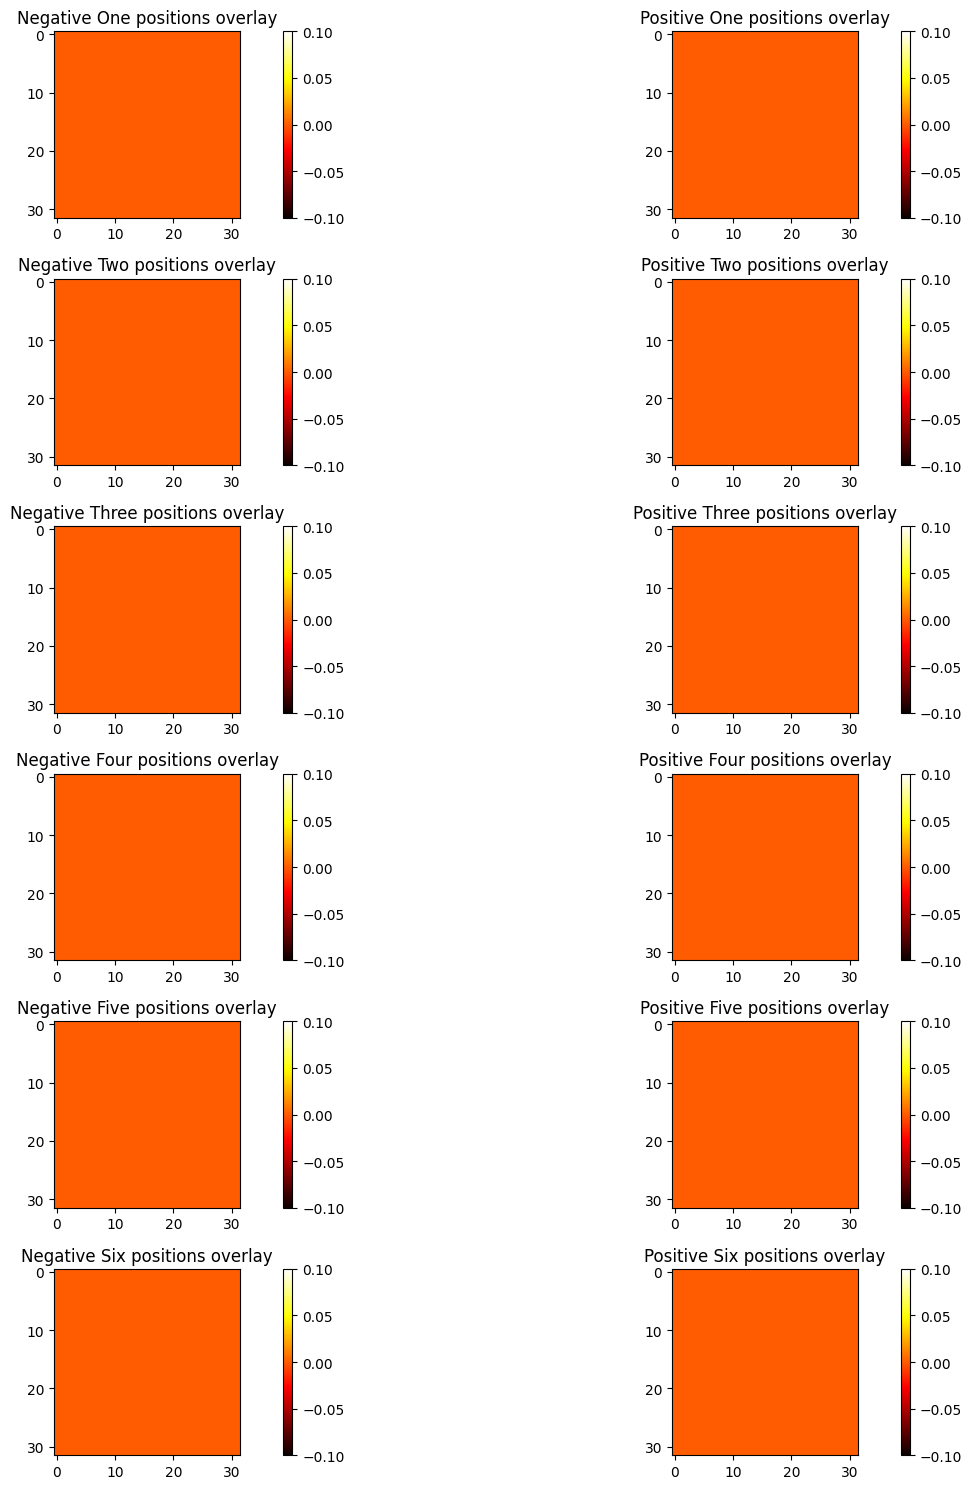

In [ ]:
#Position Overlay

fig, axs = plt.subplots(tm.number_of_classes, 2, figsize=(15, 15))  # Create a figure with two subplots
polarity_labels = ["Negative", "Positive"]
heatmap = np.zeros((tm.number_of_classes,2,32,32), dtype=np.uint16)

for Class in range(tm.number_of_classes):
    # heatmap.append([])*
    for polarity in [0, 1]:
        # heatmap[Class].append([])
        # heatmap[Class][polarity].append(np.zeros((35, 35), dtype=np.uint16))
        count = 0
        for patch in extreme_patches[Class][polarity][:50]:
            #for weight in extreme_weights[-10:]:
            # Get the x and y ranges for the patch
            if (patch.xMax<patch.xMin):upOrDown = -1
            else: upOrDown = 1
            x_range = range(patch.xMin, patch.xMax+3, upOrDown)
            if (patch.yMax<patch.yMin):upOrDown = -1
            else: upOrDown = 1
            y_range = range(patch.yMin, patch.yMax+3, upOrDown)

            # Update the corresponding pixels in the heatmap
            for weight in range(abs(extreme_weights[Class, polarity, count].astype(int))):
                for x in x_range:
                    for y in y_range:
                        heatmap[Class, polarity, x, y] += 1               
        count += 1

        # Visualize the heatmap in the corresponding subplot
        ax = axs[Class][polarity]  # Select the appropriate subplot
        im = ax.imshow(heatmap[Class, polarity], cmap='hot')
        ax.set_title(polarity_labels[polarity] + " " + str(labels[Class]) + " positions overlay")
        fig.colorbar(im, ax=ax)
print("Show heatmap of most interesting areas")
plt.tight_layout()  # Adjust spacing between subplots
plt.show()


Plot dominant color of patch over its position square


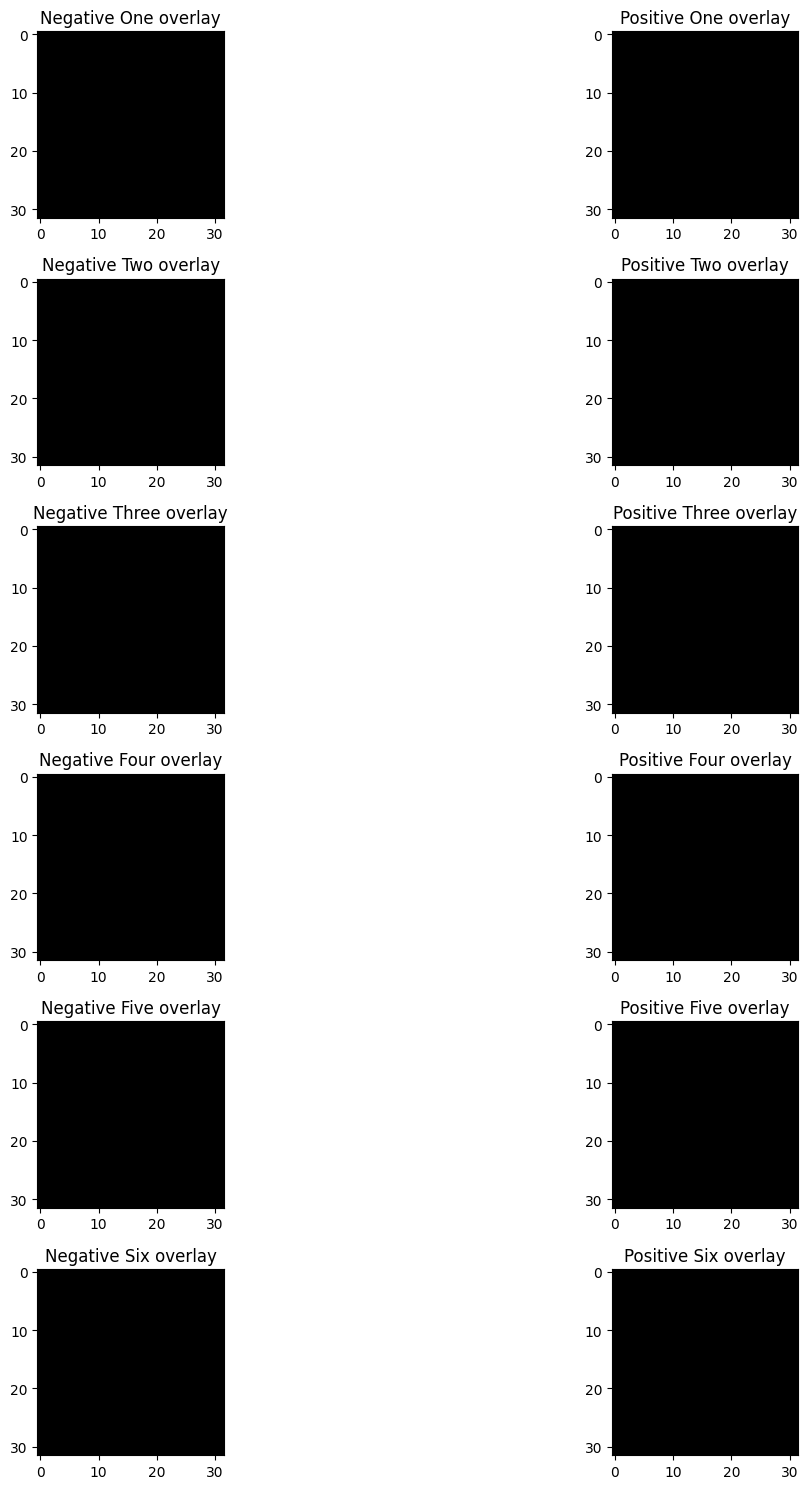

In [ ]:
#Colored Position Overlay
fig, axs = plt.subplots(tm.number_of_classes, 2, figsize=(15,15))  # Create a figure with two subplots
colormap = np.zeros((tm.number_of_classes,2, 32, 32, 3), dtype=np.uint16)

for Class in range(tm.number_of_classes):
    for polarity in [0,1]:
        count = 0
        for patch in extreme_patches[Class][polarity][:50]:
            # Get the x and y ranges for the patch
            if (patch.xMax < patch.xMin):
                upOrDown = -1
            else:
                upOrDown = 1
            x_range = range(patch.xMin, patch.xMax+3, upOrDown)
            if (patch.yMax < patch.yMin):
                upOrDown = -1
            else:
                upOrDown = 1
            y_range = range(patch.yMin, patch.yMax+3, upOrDown)

            # Update the corresponding pixels in the colormap
            for weight in range(abs(extreme_weights[Class, polarity, count].astype(int))*2):
                for x in x_range:
                    for y in y_range:
                        colormap[Class, polarity, x, y, patch.dominant_color(value=1)] += 20

            count += 1

        # Visualize the heatmap in the corresponding subplot
        # ax = axs[Class]  # Select the appropriate subplot
        ax = axs[Class, polarity]  # Select the appropriate subplot
        im = ax.imshow(colormap[Class, polarity,:,:,:])
        ax.set_title(polarity_labels[polarity] + " " + str(labels[Class]) + " overlay")
print("Plot dominant color of patch over its position square")
plt.tight_layout()  # Adjust spacing between subplots
plt.show()


ValueError: operands could not be broadcast together with shapes (3,) (3,2) 

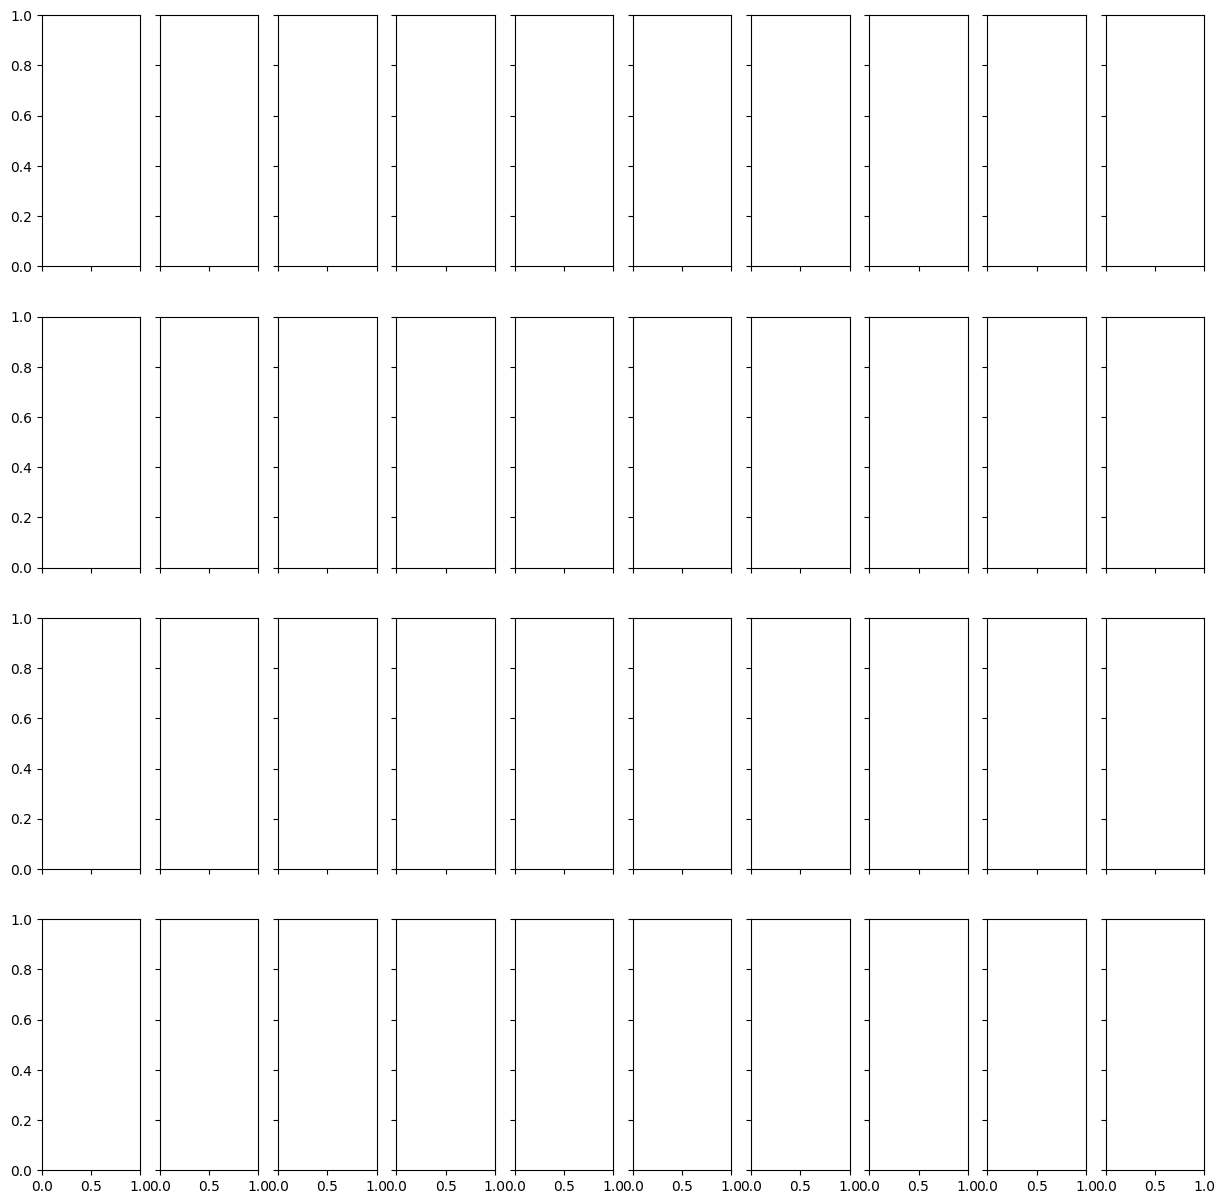

In [ ]:
#Generate image randomly
fig, axs = plt.subplots(tm.number_of_classes, 10, figsize=(15,15), sharex=True, sharey=True) #figure with subplots
image = np.zeros((32,32,3), dtype=np.uint16) #resulting image
probs = np.zeros((n_extreme_patches)) #weighted picking of patches

#extreme_patches are 50 most weighted patches for both polarities
#extreme_weights is corresponding weights to each of those patches
for Class in range(tm.number_of_classes):
    image = np.zeros((32,32,3), dtype=np.uint16)
    for polarity in [1]: #only positive
        for sample in range(10):
            for iterations in range(300):
                #pick a random patch
                probs=extreme_weights[Class, 1, :n_extreme_patches]
                probs= probs / np.sum(probs) #needs to be proportional
                random_patch = np.random.choice(range(n_extreme_patches), p=probs)
                patch = extreme_patches[Class, polarity, random_patch]
                
                #repeat_for_big_spaces
                # for k in range((len(x_range)+len(y_range))//6):
                for k in range(2):
                    # pick its random cooridnate
                    x_coor = np.random.randint(min(patch.xMin, patch.xMax), max(patch.xMin, patch.xMax) + 1)
                    y_coor = np.random.randint(min(patch.yMin, patch.yMax), max(patch.yMin, patch.yMax) + 1)
                    # add it to the mix ##try mean value rather than addition
                    # image[x_coor:(x_coor+3), y_coor:(y_coor+3)] += patch.patch_info.astype(np.uint8)[:,:]
                    for xi, x in enumerate(range(x_coor,x_coor+3)):
                        for yi, y in enumerate(range(y_coor,y_coor+3)):
                            image[x,y] = np.minimum(image[x,y] + patch.patch_info.astype(np.uint8)[xi,yi], 254)
    
            ax = axs[Class, sample]  # Select the appropriate subplot
            # im = ax.imshow(image[:,:,:], cmap='Blues')
            im = ax.imshow(image[:,:,:])
            ax.set_title(str(sample) + " " + str(labels[Class]))
plt.tight_layout()
plt.show()

Unassigned bits: [548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575]
here 86.0
[[[[0, 0], [0, 29]], 'min X'], [[[0, 0], [29, 58]], 'min Y'], [[[0, 0], [58, 66], [82, 90], [106, 114], [130, 138], [154, 162], [178, 186], [202, 210], [226, 234], [250, 258]], 'Red'], [[[0, 0], [66, 74], [90, 98], [114, 122], [138, 146], [162, 170], [186, 194], [210, 218], [234, 242], [258, 266]], 'Green'], [[[0, 0], [74, 82], [98, 106], [122, 130], [146, 154], [170, 178], [194, 202], [218, 226], [242, 250], [266, 274]], 'Blue'], [[[0, 0], [332, 340], [356, 364], [380, 388], [404, 412], [428, 436], [452, 460], [476, 484], [500, 508], [524, 532]], 'neg Red'], [[[0, 0], [340, 348], [364, 372], [388, 396], [412, 420], [436, 444], [460, 468], [484, 492], [508, 516], [532, 540]], 'neg Green'], [[[0, 0], [348, 356], [372, 380], [396, 404], [420, 428], [444, 452], [468, 476], [492, 500], [516, 524], [540, 548]], 'neg Blue'], [

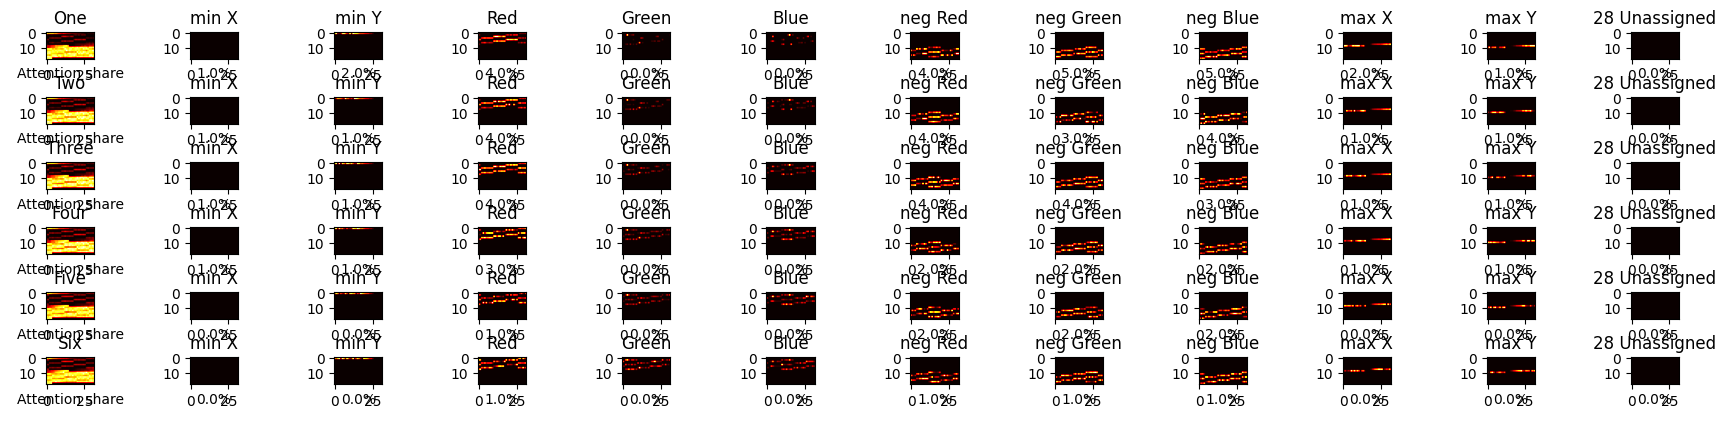

In [ ]:
#which area has the most mentions of both positive and negative literals
def draw_literals_importance(tm):
    bits = [[[[0,0]], "min X"],
            [[[0,0]], "min Y"],
            [[[0,0]], "Red"],
            [[[0,0]], "Green"],
            [[[0,0]], "Blue"],
            
            [[[0,0]], "neg Red"],
            [[[0,0]], "neg Green"],
            [[[0,0]], "neg Blue"],
            [[[0,0]], "max X"],
            [[[0,0]], "max Y"]]
    
    k = 0
    C = 29
    bits[0][0].append([k, k+C])
    
    k = 29
    C = 29
    bits[1][0].append([k, k+C])
        
    k = 58
    C = resolution
    for pixel in range(patch_dim[0]*patch_dim[1]):
      bits[2][0].append([k, k+C])
      k+=C
      bits[3][0].append([k, k+C])
      k+=C
      bits[4][0].append([k, k+C])
      k+=C
  
    k = 332 # negative part
    for pixel in range(patch_dim[0]*patch_dim[1]):
      bits[5][0].append([k, k+C])
      k+=C
      bits[6][0].append([k, k+C])
      k+=C
      bits[7][0].append([k, k+C])
      k+=C
   
    k = 274
    C = 29
    bits[8][0].append([k, k+C])
    
    k = 303
    C = 29
    bits[9][0].append([k, k+C])
    
    # Create a set of all bit positions
    all_bits = set(range(576))

    # Iterate through the bits array and remove the mentioned bit positions from the set
    for group in bits:
        for bit_range in group[0]:
            all_bits -= set(range(bit_range[0], bit_range[1]))

    # If there are any remaining positions in the set, add them to the bits array under the "unassigned" group
    if all_bits:
        unassigned_ranges = []
        # Convert the set to a sorted list
        unassigned_list = sorted(list(all_bits))
        # Group consecutive numbers into ranges
        start = unassigned_list[0]
        end = start
        for i in range(1, len(unassigned_list)):
            if unassigned_list[i] == end + 1:
                end = unassigned_list[i]
            else:
                unassigned_ranges.append([start, end+1])
                start = unassigned_list[i]
                end = start
        unassigned_ranges.append([start, end+1])
        
        # Count the unassigned bits
        num_of_unassigned_bits = len(all_bits)
        
        # Print the unassigned bits
        print(f"Unassigned bits: {unassigned_list}")
        
        # Add the unassigned bits to the bits array with the appropriate name
        bits.append([unassigned_ranges, f"{num_of_unassigned_bits} Unassigned"])
        


    
  
    classes = tm.number_of_classes
        
    fig, axs = plt.subplots(classes*2, len(bits)+1, figsize=(22, 5))  # Create subplots for the line of images
    
    #read the whole heat map
    block = np.zeros(577)
    bit_share= np.zeros((classes,len(bits)))
    for Class in range(classes):
        for Clause in range(int((tm.number_of_clauses))):
            for literal in range(576): #num of literals defines size of the block
                block[literal] += (tm.get_ta_action(Clause, literal, Class) * abs((tm.get_weight(the_class=Class,clause=Clause, polarity=0))))
    
        image_org = block[:576].reshape(-1,32)
        axs[Class*2,0].imshow(image_org, cmap='hot')
        axs[Class*2,0].set_title(labels[Class])
        
        # Add text beneath the image
        axs[Class*2+1, 0].text(0.5, 0.5, "Attention share", ha='center')
        axs[Class*2+1, 0].axis('off')
    
        
        
        #mask it to split into bit_lengths
        for k in range(len(bits)): #k is a group of bits
            # Create image with all pixels set to 0
            image = np.zeros((image_org.shape[0], image_org.shape[1]), dtype=np.uint8)
            image = image.reshape(-1)
            for range_of_bits in bits[k][0]:
                image[range_of_bits[0]:range_of_bits[1]] = block[range_of_bits[0]:range_of_bits[1]]
            image = image[:576].reshape(-1,32)
            
            
            axs[Class*2, k+1].imshow(image, cmap='hot')
            # axs[Class*2, k+1].axis('off')
            axs[Class*2, k+1].set_title(bits[k][1])
            
            # calculate interesting data
            bit_share[Class, k] = ((np.sum(image)/np.sum(block))*100).astype(int)
            
            # Add text beneath the images
            axs[Class*2+ 1, k+1].text(0.5, 0.5, f"{bit_share[Class,k]}%", ha='center')
            # axs[Class*2+ 1, k+1].text(0.5, 0.3, f"From {bits[k][0][0]}", ha='center')
            # axs[Class*2+ 1, k+1].text(0.5, 0.1, f"to {bits[k][-2][1]}", ha='center')
            axs[Class*2+ 1, k+1].axis('off')

    # Show the plot
    print("here", np.sum(bit_share))
    print(bits)
    plt.show()
draw_literals_importance(tm)


In [ ]:
# Define two example datasets
dataset1 = np.array([
    [
        [[1, 1, 1], [2, 2, 2], [3, 3, 3]],
        [[4, 4, 4], [5, 5, 5], [6, 6, 6]],
        [[7, 7, 7], [8, 8, 8], [9, 9, 9]],
    ],
    [
        [[10, 10, 10], [11, 11, 11], [12, 12, 12]],
        [[13, 13, 13], [14, 14, 14], [15, 15, 15]],
        [[16, 16, 16], [17, 17, 17], [18, 18, 18]],
    ],
])

dataset2 = np.array([
    [
        [[19, 19, 19], [20, 20, 20], [21, 21, 21]],
        [[22, 22, 22], [23, 23, 23], [24, 24, 24]],
        [[25, 25, 25], [26, 26, 26], [27, 27, 27]],
    ],
    [
        [[28, 28, 28], [29, 29, 29], [30, 30, 30]],
        [[31, 31, 31], [32, 32, 32], [33, 33, 33]],
        [[34, 34, 34], [35, 35, 35], [36, 36, 36]],
    ],
])

# Concatenate the datasets along the last axis
concatenated_dataset = np.concatenate((dataset1, dataset2), axis=-1)
print(dataset1)
print(concatenated_dataset)


[[[[ 1  1  1]
   [ 2  2  2]
   [ 3  3  3]]

  [[ 4  4  4]
   [ 5  5  5]
   [ 6  6  6]]

  [[ 7  7  7]
   [ 8  8  8]
   [ 9  9  9]]]


 [[[10 10 10]
   [11 11 11]
   [12 12 12]]

  [[13 13 13]
   [14 14 14]
   [15 15 15]]

  [[16 16 16]
   [17 17 17]
   [18 18 18]]]]
[[[[ 1  1  1 19 19 19]
   [ 2  2  2 20 20 20]
   [ 3  3  3 21 21 21]]

  [[ 4  4  4 22 22 22]
   [ 5  5  5 23 23 23]
   [ 6  6  6 24 24 24]]

  [[ 7  7  7 25 25 25]
   [ 8  8  8 26 26 26]
   [ 9  9  9 27 27 27]]]


 [[[10 10 10 28 28 28]
   [11 11 11 29 29 29]
   [12 12 12 30 30 30]]

  [[13 13 13 31 31 31]
   [14 14 14 32 32 32]
   [15 15 15 33 33 33]]

  [[16 16 16 34 34 34]
   [17 17 17 35 35 35]
   [18 18 18 36 36 36]]]]


Unassigned bits: [580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607]


IndexError: index 28807 is out of bounds for axis 0 with size 28800

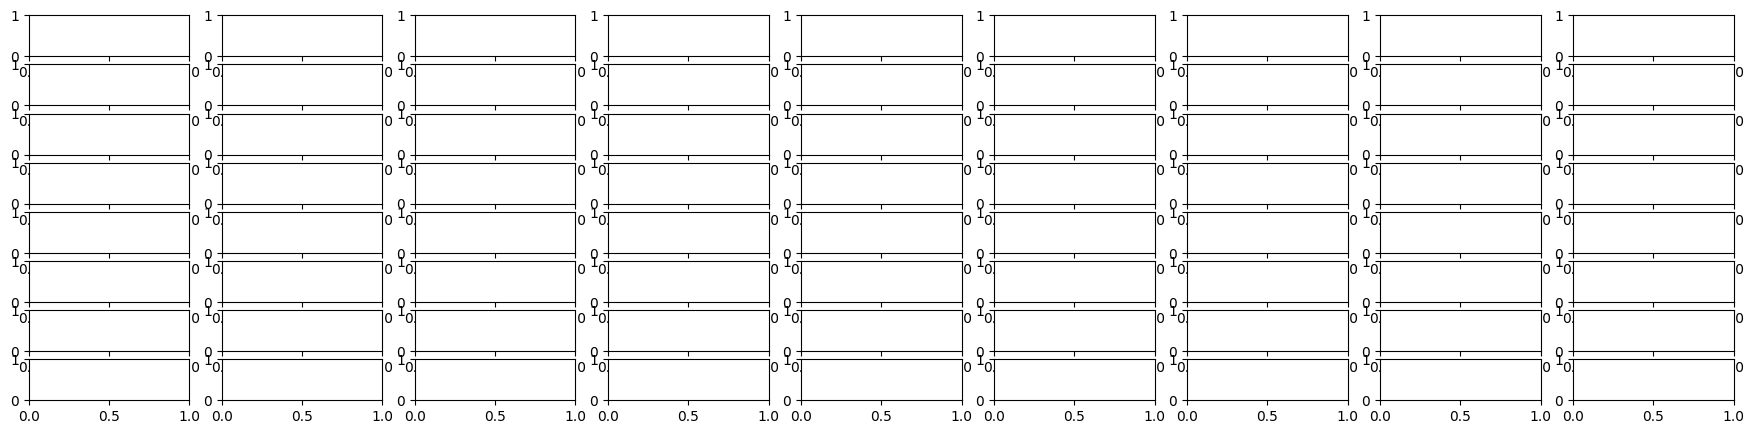

In [ ]:
#which area has the most mentions of both positive and negative literals
def draw_literals_importance(tm):

    block_size = 608
    bits = [
        [
            [[0, 58], [522, 580]], 
            "Position"
        ],
        [
            [[58, 66]], 
            "Gradient Magnitude"
        ],
        [
            [[66, 74]], 
            "Gradient Angle"
        ],
        [
            [[74, 290]], 
            "Colour"
        ],
        [
            [[290, 298]], 
            "neg Gradient Magnitude"
        ],
        [
            [[298, 306]], 
            "neg Gradient Angle"
        ],
        [
            [[306, 522]], 
            "neg Colour"
        ]
    ]


    
    # Create a set of all bit positions
    all_bits = set(range(block_size))

    # Iterate through the bits array and remove the mentioned bit positions from the set
    for group in bits:
        for bit_range in group[0]:
            all_bits -= set(range(bit_range[0], bit_range[1]))



        

    # If there are any remaining positions in the set, add them to the bits array under the "unassigned" group
    if all_bits:
        unassigned_ranges = []
        # Convert the set to a sorted list
        unassigned_list = sorted(list(all_bits))
        # Group consecutive numbers into ranges
        start = unassigned_list[0]
        end = start
        for i in range(1, len(unassigned_list)):
            if unassigned_list[i] == end + 1:
                end = unassigned_list[i]
            else:
                unassigned_ranges.append([start, end+1])
                start = unassigned_list[i]
                end = start
        unassigned_ranges.append([start, end+1])
        
        # Count the unassigned bits
        num_of_unassigned_bits = len(all_bits)
        
        # Print the unassigned bits
        print(f"Unassigned bits: {unassigned_list}")
        
        # Add the unassigned bits to the bits array with the appropriate name
        bits.append([unassigned_ranges, f"{num_of_unassigned_bits} Unassigned"])
        


    
  
    classes = tm.number_of_classes
        
    fig, axs = plt.subplots(classes*2, len(bits)+1, figsize=(22, 5))  # Create subplots for the line of images
    
    #read the whole heat map
    block = np.zeros(block_size)
    bit_share= np.zeros((classes,len(bits)))
    for Class in range(classes):
        for Clause in range(int((tm.number_of_clauses))):
            for literal in range(block_size): #num of literals defines size of the block
                block[literal] += (tm.get_ta_action(Clause, literal, Class) * abs((tm.get_weight(the_class=Class,clause=Clause, polarity=0))))
    
        image_org = block[:block_size].reshape(-1,32)
        axs[Class*2,0].imshow(image_org, cmap='hot')
        axs[Class*2,0].set_title(labels[Class])
        
        # Add text beneath the image
        axs[Class*2+1, 0].text(0.5, 0.5, "Attention share", ha='center')
        axs[Class*2+1, 0].axis('off')
    
        
        
        #mask it to split into bit_lengths
        for k in range(len(bits)): #k is a group of bits
            # Create image with all pixels set to 0
            image = np.zeros((image_org.shape[0], image_org.shape[1]), dtype=np.uint8)
            image = image.reshape(-1)
            for range_of_bits in bits[k][0]:
                image[range_of_bits[0]:range_of_bits[1]] = block[range_of_bits[0]:range_of_bits[1]]
            image = image[:block_size].reshape(-1,32)
            
            
            axs[Class*2, k+1].imshow(image, cmap='hot')
            # axs[Class*2, k+1].axis('off')
            axs[Class*2, k+1].set_title(bits[k][1])
            
            # calculate interesting data
            bit_share[Class, k] = ((np.sum(image)/np.sum(block))*100).astype(int)
            
            # Add text beneath the images
            axs[Class*2+ 1, k+1].text(0.5, 0.5, f"{bit_share[Class,k]}%", ha='center')
            # axs[Class*2+ 1, k+1].text(0.5, 0.3, f"From {bits[k][0][0]}", ha='center')
            # axs[Class*2+ 1, k+1].text(0.5, 0.1, f"to {bits[k][-2][1]}", ha='center')
            axs[Class*2+ 1, k+1].axis('off')

    # Show the plot
    print("here", np.sum(bit_share))
    print(bits)
    plt.show()
draw_literals_importance(tm)
